# Live Casino Recommendation System — Experimentation Notebook
**Quantum Horizon | Phase 1 — LightFM Hybrid Model**

---

### Notebook Flow
```
CELL 0   → Installs & Imports
CELL 1   → Simulate Data (Games, Users, Transactions)
CELL 2   → Basic EDA
CELL 2B  → Advanced EDA (Behavior Patterns & Data Geometry)
CELL 3   → Feature Engineering (Interaction Matrix + User/Item Features)
CELL 3B  → Feature Ablation (Model Selection, Pre-Final Training)
CELL 4   → LightFM Final Training
CELL 5   → Final Evaluation (Precision@K, AUC, NDCG)
CELL 5B  → Ranking Confusion Matrix + PR Diagnostics
CELL 6   → Post-Model Correlation Diagnostics (Feature Impact + Popularity Bias)
CELL 7   → Model Output Visualizations
CELL 8   → Auto Interpretation
```

In [2]:
print("hello world")

hello world


In [3]:
!python --version

Python 3.10.19


In [4]:
import lightfm

In [5]:
import pandas as pd 
import numpy as np
import random  
import os 
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime, timedelta
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score 
from lightfm.cross_validation import random_train_test_split

warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', None)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print('All imports successful')

All imports successful


---
## CELL 1 — Simulate Data
> Simulates MongoDB collections: games, users, transactions
>
 → pandas load

In [7]:
#CONFIG 
N_USERS  = 5000
N_DAYS   = 90
TODAY    = datetime.now()

#GAMES
GAME_TYPES = {
    'Baccarat':    {'count': 12, 'min_bet_range': (500,  2000),  'max_bet_range': (50000,  200000)},
    'Roulette':    {'count': 10, 'min_bet_range': (100,  1000),  'max_bet_range': (20000,  100000)},
    'Blackjack':   {'count': 10, 'min_bet_range': (500,  2000),  'max_bet_range': (50000,  150000)},
    'DragonTiger': {'count': 8,  'min_bet_range': (200,  1000),  'max_bet_range': (20000,   80000)},
    'SicBo':       {'count': 6,  'min_bet_range': (200,  1000),  'max_bet_range': (30000,  100000)},
    'Poker':       {'count': 8,  'min_bet_range': (1000, 5000),  'max_bet_range': (100000, 500000)},
    'CrazyTime':   {'count': 4,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   50000)},
    'Monopoly':    {'count': 4,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   50000)},
    'BacBo':       {'count': 4,  'min_bet_range': (500,  2000),  'max_bet_range': (50000,  150000)},
    'AndarBahar':  {'count': 6,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   50000)},
    'TeenPatti':   {'count': 4,  'min_bet_range': (200,  1000),  'max_bet_range': (20000,   80000)},
    'Megaball':    {'count': 4,  'min_bet_range': (100,  500),   'max_bet_range': (10000,   40000)},
}
VENDORS = ['Evolution', 'Pragmatic Play', 'Ezugi', 'Playtech', 'SA Gaming']

games, game_counter = [], 1476000   #games ko store krne k liye ek empty list and starting ID number for these games
for game_type, cfg in GAME_TYPES.items():
    for i in range(cfg['count']):  #creates multiple versions of the game
        min_bet  = random.choice(range(cfg['min_bet_range'][0], cfg['min_bet_range'][1], 100))
        max_bet  = random.choice(range(cfg['max_bet_range'][0], cfg['max_bet_range'][1], 1000))   #will create different min and max bet for each game(more realistic)
        subs     = ['All Games']  
        if i < 3: subs.append('Top Games')
        if i < 5: subs.append('Most Popular')
            
        games.append({
            'gameId':        str(game_counter + i),
            'gameName':      f"{game_type} ({800 + len(games)})",
            'gameType':      game_type,
            'vendor':        random.choice(VENDORS),
            'minBet':        min_bet,
            'maxBet':        max_bet,
            'betRange':      max_bet - min_bet,   #FEATURE ENGINEERED
            'isTopGame':     'Top Games' in subs,
            'isMostPopular': 'Most Popular' in subs,
            'gameStatus':    'ON',
        })
    game_counter += cfg['count']   #INCREASES ID COUNTER FOR THE NEXT GAME

games_df = pd.DataFrame(games)
print(f'✅ Games: {len(games_df)} | Types: {games_df["gameType"].nunique()}')

✅ Games: 80 | Types: 12


In [8]:
#USERS
USER_ARCHETYPES = {
    'high_roller': {'proportion': 0.05, 'sessions_pw': (5,14),  'bet_mult': (5,20),  'preferred': ['Baccarat','Poker','Blackjack'], 'duration': (30,120), 'hours': [19,20,21,22,23]},
    'regular':     {'proportion': 0.25, 'sessions_pw': (2,7),   'bet_mult': (1,5),   'preferred': ['Baccarat','Roulette','DragonTiger','SicBo'], 'duration': (10,45),  'hours': [18,19,20,21,22]},
    'casual':      {'proportion': 0.40, 'sessions_pw': (1,3),   'bet_mult': (1,2),   'preferred': ['CrazyTime','Monopoly','Megaball','AndarBahar'], 'duration': (5,20),   'hours': [12,13,18,19,20,21]},
    'explorer':    {'proportion': 0.20, 'sessions_pw': (2,5),   'bet_mult': (1,3),   'preferred': list(GAME_TYPES.keys()), 'duration': (5,30),   'hours': [10,14,18,20,22]},
    'dormant':     {'proportion': 0.10, 'sessions_pw': (0,1),   'bet_mult': (1,2),   'preferred': ['AndarBahar','TeenPatti'], 'duration': (2,10),   'hours': [20,21]},
}

archetype_list = []
for a, cfg in USER_ARCHETYPES.items():
    archetype_list.extend([a] * int(N_USERS * cfg['proportion']))  #5000 users m se proportinality of the users are being added to the list
    
while len(archetype_list) < N_USERS: 
    archetype_list.append('casual') 
random.shuffle(archetype_list)

users_df = pd.DataFrame([
    {'userId':    f'u_{str(i+1).zfill(5)}',
     'archetype': archetype_list[i],
     'country':   random.choice(['IN','AE','GB','US','SG','MY']),
     'device':    random.choice(['mobile','desktop','tablet']),
     'joinedAt':  (TODAY - timedelta(days=random.randint(1, N_DAYS))).isoformat()}
    for i in range(N_USERS)
])

print(f'✅ Users: {len(users_df)}')
print(users_df['archetype'].value_counts())

✅ Users: 5000
archetype
casual         2000
regular        1250
explorer       1000
dormant         500
high_roller     250
Name: count, dtype: int64


In [9]:
# ── TRANSACTIONS ────────────────────────────────────────
transactions = []

for _, user in users_df.iterrows():
    cfg           = USER_ARCHETYPES[user['archetype']]
    total_sessions = int((N_DAYS / 7) * random.randint(*cfg['sessions_pw']))
    if total_sessions == 0:
        continue

    user_games = games_df[games_df['gameType'].isin(cfg['preferred'])]
    n_unique   = min(random.randint(2, 10 if user['archetype']=='explorer' else 5), len(user_games))
    if n_unique == 0:
        continue

    played_games = user_games.sample(n=n_unique, replace=False)
    weights      = np.random.dirichlet(np.ones(n_unique))

    for idx, (_, game) in enumerate(played_games.iterrows()):
        game_sessions = max(1, int(total_sessions * weights[idx]))
        for _ in range(game_sessions):
            days_ago   = random.randint(0, N_DAYS - 1)
            hour       = random.choice(cfg['hours'])
            ts         = (TODAY - timedelta(days=days_ago, minutes=random.randint(0,59))).replace(hour=hour)
            bet        = int(game['minBet'] * random.uniform(*cfg['bet_mult']))
            bet        = max(game['minBet'], min(bet, game['maxBet']))
            transactions.append({
                'userId':          user['userId'],
                'gameId':          game['gameId'],
                'gameType':        game['gameType'],
                'betAmount':       bet,
                'sessionDuration': random.randint(*cfg['duration']),
                'outcome':         random.choices(['win','loss','break_even'], weights=[0.35,0.55,0.10])[0],
                'timestamp':       ts.isoformat(),
                'hourOfDay':       ts.hour,
                'dayOfWeek':       ts.strftime('%A'),
            })

transactions_df = pd.DataFrame(transactions)
transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'])
print(f'✅ Transactions: {len(transactions_df):,}')
print(f'Unique users with activity: {transactions_df["userId"].nunique():,}')
print(f'Avg transactions/user: {len(transactions_df)/transactions_df["userId"].nunique():.1f}')

✅ Transactions: 194,164
Unique users with activity: 4,766
Avg transactions/user: 40.7


---
## CELL 2 — Basic EDA
> In real project: run this on actual MongoDB data first.

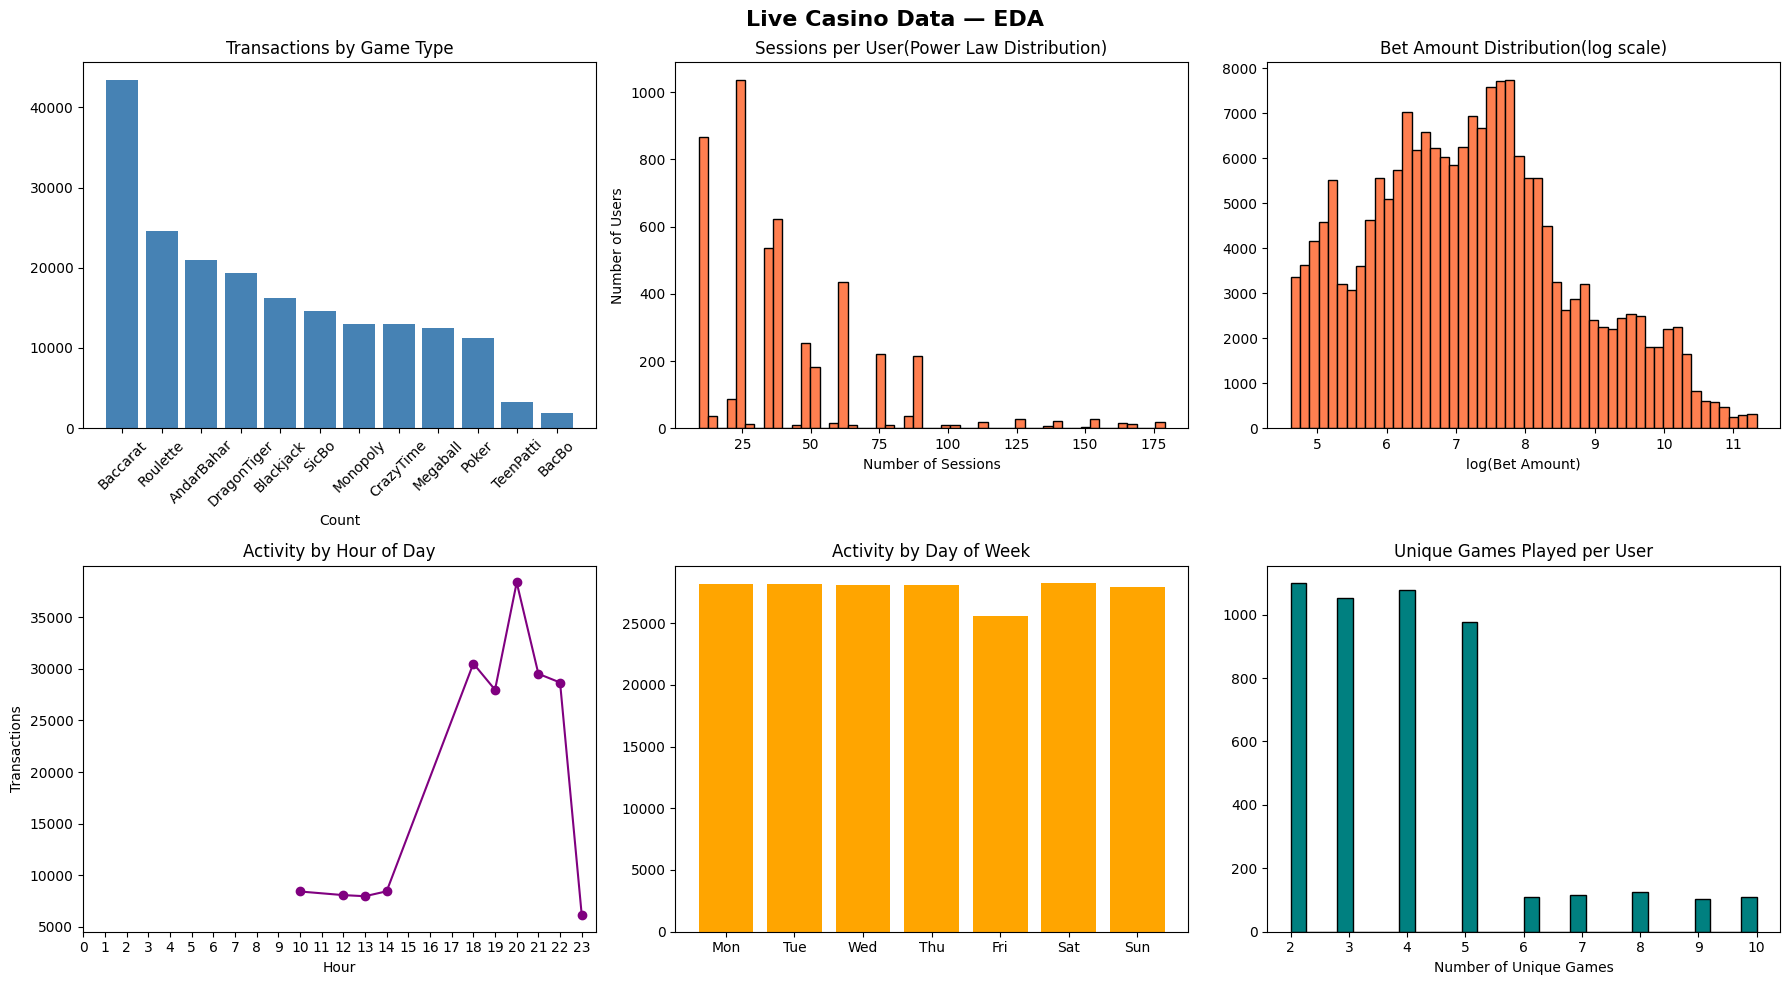


📊 Key Stats:
  Total transactions:         194,164
  Active users (≥1 tx):       4,766
  Median sessions/user:       36
  Avg unique games/user:      4.0
  Interaction matrix density: 4.75%


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Live Casino Data — EDA', fontsize=16, fontweight='bold')

# 1. Transactions per game type
game_type_counts = transactions_df.merge(games_df[['gameId','gameType']], on='gameId', suffixes=('','_g'))['gameType_g'].value_counts() if 'gameType' not in transactions_df.columns else transactions_df['gameType'].value_counts()
axes[0,0].bar(game_type_counts.index, game_type_counts.values, color='steelblue')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_title('Transactions by Game Type')
axes[0,0].set_xlabel('Count')


#2. Sessions per user(power law - should be skewed)
user_session_counts = transactions_df.groupby('userId').size()
axes[0,1].hist(user_session_counts, bins=50, color='coral', edgecolor='black', orientation='vertical')
axes[0,1].set_title('Sessions per User(Power Law Distribution)')
axes[0,1].set_xlabel('Number of Sessions')
axes[0,1].set_ylabel('Number of Users')


#3. Bet amount distribution
axes[0, 2].hist(np.log1p(transactions_df['betAmount']), bins = 50, color = 'coral', edgecolor = 'black')
axes[0, 2].set_title('Bet Amount Distribution(log scale)')
axes[0, 2].set_xlabel('log(Bet Amount)')


# 4. Activity by hour of day
hourly = transactions_df.groupby('hourOfDay').size()
axes[1,0].plot(hourly.index, hourly.values, marker='o', color='purple')
axes[1,0].set_title('Activity by Hour of Day')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Transactions')
axes[1,0].set_xticks(range(0,24))

# 5. Activity by day of week
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily = transactions_df.groupby('dayOfWeek').size().reindex(day_order)
axes[1,1].bar(range(7), daily.values, color='orange', tick_label=[d[:3] for d in day_order])
axes[1,1].set_title('Activity by Day of Week')

# 6. Unique games played per user
unique_games_per_user = transactions_df.groupby('userId')['gameId'].nunique()
axes[1,2].hist(unique_games_per_user, bins=30, color='teal', edgecolor='black')
axes[1,2].set_title('Unique Games Played per User')
axes[1,2].set_xlabel('Number of Unique Games')

plt.tight_layout()
plt.show()

print('\n📊 Key Stats:')
print(f'  Total transactions:         {len(transactions_df):,}')
print(f'  Active users (≥1 tx):       {transactions_df["userId"].nunique():,}')
print(f'  Median sessions/user:       {user_session_counts.median():.0f}')
print(f'  Avg unique games/user:      {unique_games_per_user.mean():.1f}')
print(f'  Interaction matrix density: {len(transactions_df.groupby(["userId","gameId"])) / (N_USERS * len(games_df)) * 100:.2f}%')

Plot 1--> Tells which game is more popular, model would eventually recommend that game more

Plot 2--> Sessions per user, ek user ek baar meh kitna sessions karta hai

Plot 3--> As per dummy data, bet is ranging between 6 to 8(log scale pe), meaning real value would range somewhere around 400 to 3000

Plot 4--> Activity by hour of day, as per this dummy data, most users are active around night

Plot 5--> Activity by day of week

Plot 6--> Most users play 2-4 unique games. Probably explorer types play 6+ games

---
## CELL 2B — Advanced EDA

In [ ]:
#3--> Computing implicit score--> Advanced eda m kaam ayega
#creating a 'target' column--> not a single column but a strength of preference(user, game) pair

transactions_df['days_ago'] = (TODAY - transactions_df['timestamp']).dt.days

interaction_agg = transactions_df.groupby(['userId', 'gameId']).agg(
    play_count = ('betAmount', 'count'),
    total_bet = ('betAmount', 'sum'),
    avg_bet = ('betAmount', 'mean'),
    avg_session_min = ('sessionDuration', 'mean'),
    last_played_days_ago = ('days_ago', 'min'),
).reset_index()


def compute_implicit_score(row):
    #recency weight
    d = row['last_played_days_ago']
    recency_w = 1.0 if d <= 7 else (0.7 if d <= 30 else(0.4 if d <= 90 else 0.2))

    freq_score = min(row['play_count']/20.0, 1.0)
    bet_score = min(row['total_bet']/500000.0, 1.0)
    session_score = min(row['avg_session_min']/60.0, 1.0)

    return round(0.35 * freq_score + 0.25 * bet_score + 0.20 * session_score + 0.20 * recency_w, 4)

interaction_agg['implicit_score'] = interaction_agg.apply(compute_implicit_score, axis = 1)

print(f"Interaction pairs: {len(interaction_agg):,}")
print(interaction_agg['implicit_score'].describe().round(3))

Interaction pairs: 19,018
count    19018.000
mean         0.372
std          0.197
min          0.104
25%          0.218
50%          0.325
75%          0.492
max          1.000
Name: implicit_score, dtype: float64


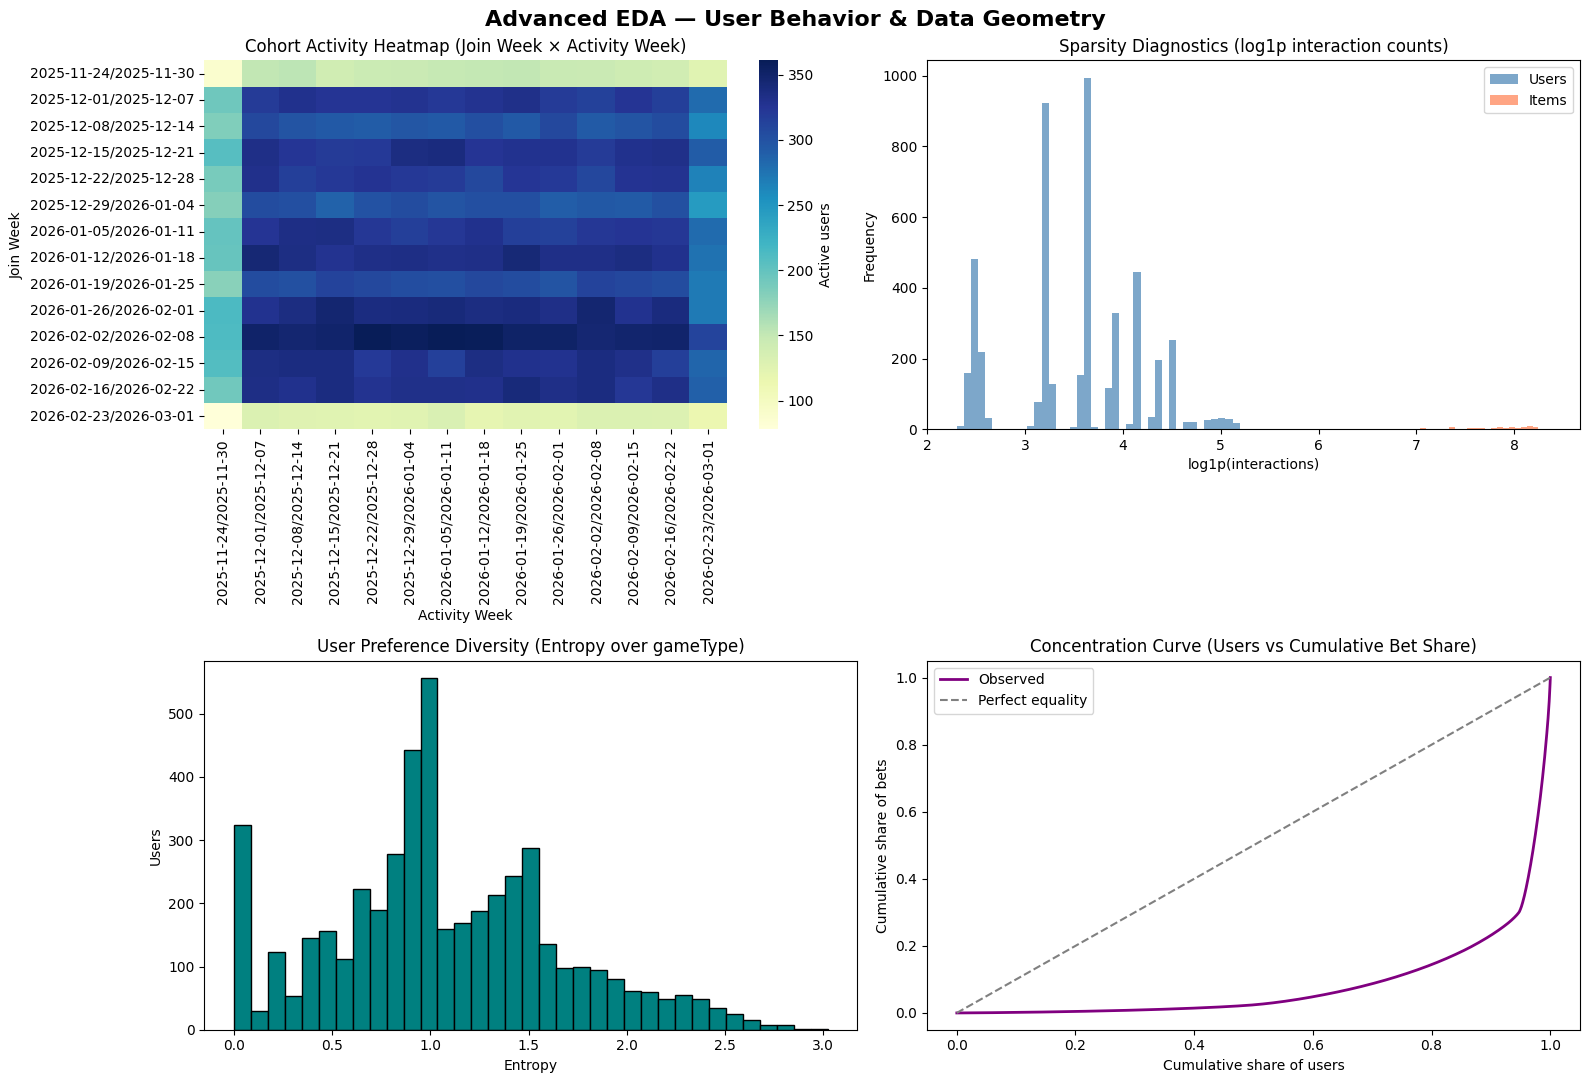

  Active users: 4,766
  Active items: 80
  Interaction density (active space): 4.99%
  Median user entropy: 0.994


In [13]:
# Advanced EDA
# Assumes: transactions_df, users_df, games_df, interaction_agg are available

# 1) User activity cohorts (join week vs activity week)
cohort_df = transactions_df[['userId', 'timestamp']].copy()
cohort_df = cohort_df.merge(users_df[['userId', 'joinedAt']], on='userId', how='left')
cohort_df['joinedAt'] = pd.to_datetime(cohort_df['joinedAt'])

cohort_df['cohort_week'] = cohort_df['joinedAt'].dt.to_period('W').astype(str)
cohort_df['activity_week'] = cohort_df['timestamp'].dt.to_period('W').astype(str)

cohort_pivot = (
    cohort_df.groupby(['cohort_week', 'activity_week'])['userId']
    .nunique()
    .reset_index(name='active_users')
    .pivot(index='cohort_week', columns='activity_week', values='active_users')
    .fillna(0)
)

# 2) Sparsity diagnostics
user_interactions = transactions_df.groupby('userId').size()
item_interactions = transactions_df.groupby('gameId').size()

# 3) Preference diversity (entropy over gameType)
gt_counts = transactions_df.groupby(['userId', 'gameType']).size().rename('n').reset_index()
user_totals = gt_counts.groupby('userId')['n'].sum().rename('total').reset_index()
entropy_df = gt_counts.merge(user_totals, on='userId', how='left')
entropy_df['p'] = entropy_df['n'] / entropy_df['total']
user_entropy = entropy_df.groupby('userId')['p'].apply(lambda x: -(x * np.log2(x + 1e-12)).sum())

# 4) Concentration (Lorenz-style cumulative share of bets)
user_bets = transactions_df.groupby('userId')['betAmount'].sum().sort_values().values
cum_users = np.arange(1, len(user_bets) + 1) / len(user_bets)
cum_bets = np.cumsum(user_bets) / np.sum(user_bets)

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Advanced EDA — User Behavior & Data Geometry', fontsize=16, fontweight='bold')

sns.heatmap(cohort_pivot, cmap='YlGnBu', ax=axes[0, 0], cbar_kws={'label': 'Active users'})
axes[0, 0].set_title('Cohort Activity Heatmap (Join Week × Activity Week)')
axes[0, 0].set_xlabel('Activity Week')
axes[0, 0].set_ylabel('Join Week')

axes[0, 1].hist(np.log1p(user_interactions), bins=40, alpha=0.7, label='Users', color='steelblue')
axes[0, 1].hist(np.log1p(item_interactions), bins=40, alpha=0.7, label='Items', color='coral')
axes[0, 1].set_title('Sparsity Diagnostics (log1p interaction counts)')
axes[0, 1].set_xlabel('log1p(interactions)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[1, 0].hist(user_entropy, bins=35, color='teal', edgecolor='black')
axes[1, 0].set_title('User Preference Diversity (Entropy over gameType)')
axes[1, 0].set_xlabel('Entropy')
axes[1, 0].set_ylabel('Users')

axes[1, 1].plot(cum_users, cum_bets, label='Observed', color='purple', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], '--', color='gray', label='Perfect equality')
axes[1, 1].set_title('Concentration Curve (Users vs Cumulative Bet Share)')
axes[1, 1].set_xlabel('Cumulative share of users')
axes[1, 1].set_ylabel('Cumulative share of bets')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

interaction_density = len(interaction_agg) / (transactions_df['userId'].nunique() * transactions_df['gameId'].nunique())
print(f'  Active users: {transactions_df["userId"].nunique():,}')
print(f'  Active items: {transactions_df["gameId"].nunique():,}')
print(f'  Interaction density (active space): {interaction_density * 100:.2f}%')
print(f'  Median user entropy: {user_entropy.median():.3f}')

Plot 1--> Color activity heatmap: kis week meh activity zada thi

Plot 2--> Blue bars are for users and orange bars are for games. Kuch users ka bohot zada interactions hai and kuch users ka bohot kam. Games ka barely minimal h since iss data meh 80 games hi use huye h

Plot 3--> Entropy via user preference diversity. 0.0 means some users play only one focused game. range of 1.0-1.5 means some users play 3-4 diverse games. and to the extreme right, 2.5+ it gradually decreases this are users who pla very diverse games

Plot 4--> about 80-90% of users cumulate about 10-20% of the revenue. the top 10% show a major drive to the revenue

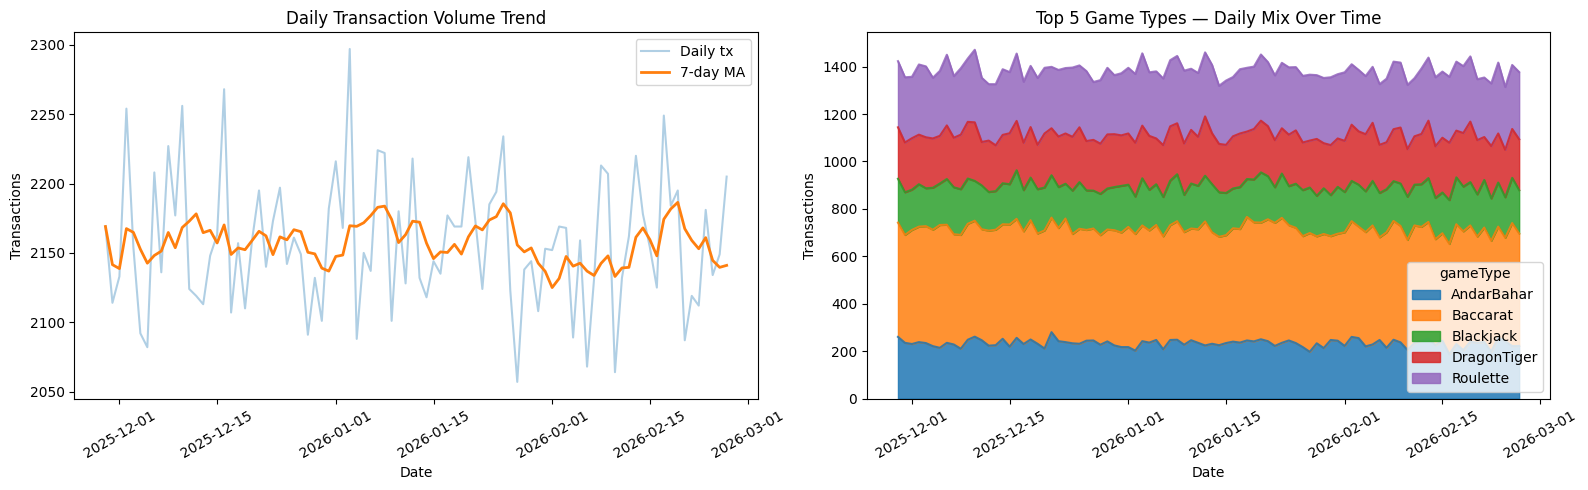

In [14]:
#Daily activity trend + 7-day moving average

plot_df = transactions_df.copy()
plot_df['date'] = plot_df['timestamp'].dt.date

daily_tx = plot_df.groupby('date').size().rename('tx_count').reset_index()
daily_tx['tx_ma7'] = daily_tx['tx_count'].rolling(7, min_periods=1).mean()

top_game_types = plot_df['gameType'].value_counts().head(5).index
stacked = (
    plot_df[plot_df['gameType'].isin(top_game_types)]
    .groupby(['date', 'gameType'])
    .size()
    .unstack(fill_value=0)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(daily_tx['date'], daily_tx['tx_count'], alpha=0.35, label='Daily tx')
axes[0].plot(daily_tx['date'], daily_tx['tx_ma7'], linewidth=2, label='7-day MA')
axes[0].set_title('Daily Transaction Volume Trend')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Transactions')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=30)

stacked.plot(kind='area', ax=axes[1], alpha=0.85)
axes[1].set_title('Top 5 Game Types — Daily Mix Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Transactions')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()  
plt.show()

Plot 1--> Daily transactions vs 7 day moving average. Orange line isme toh stable dikh raha h qki dummy data hai, but real data meh in cases of promotions, festivals we can see a spike on the orange line as well.

Plot 2--> Layers ka thickness does not change over time since ye toh dummy data hai. iss plot se yeh pata chalega ki koi game achanak se popular/unpopular hua ya nahi

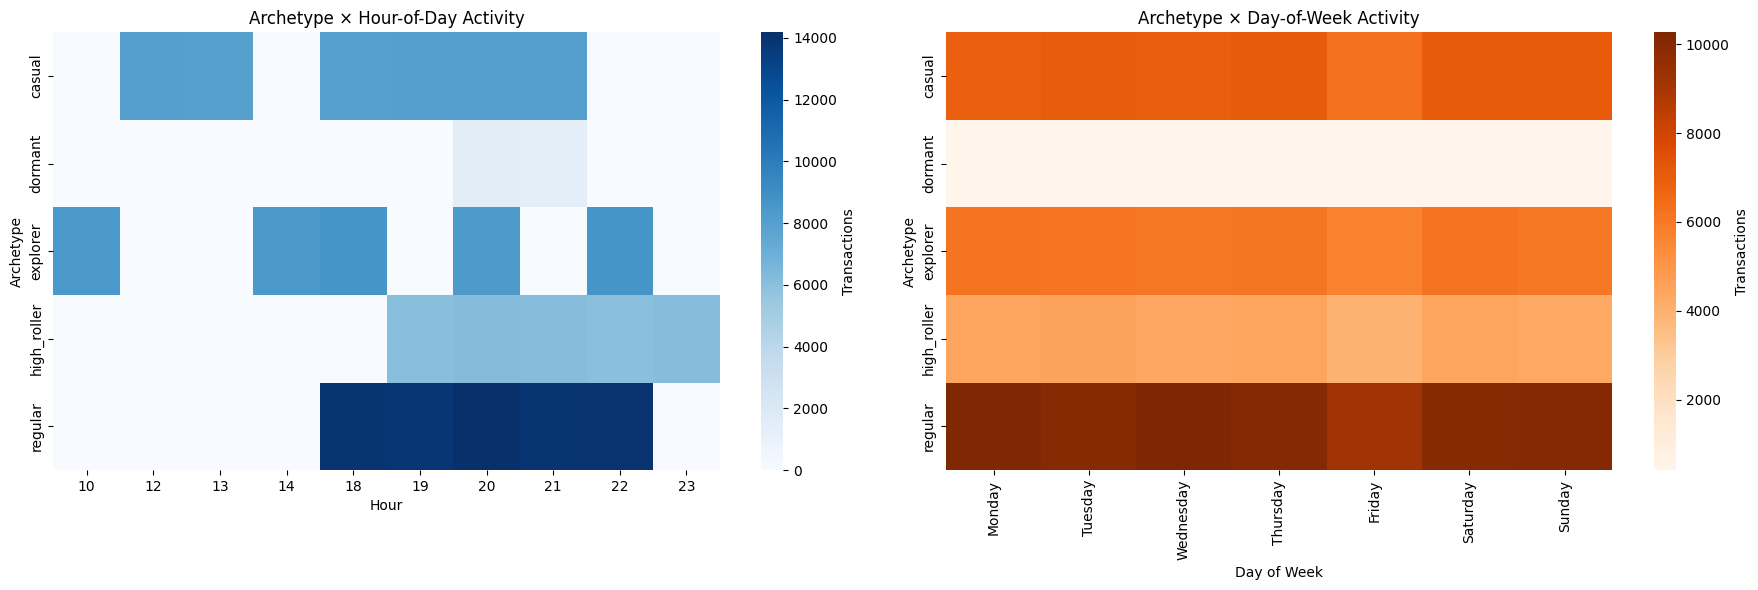

In [15]:
#Segment behavior heatmaps (Archetype × Hour, Archetype × Day)

seg_df = transactions_df.merge(users_df[['userId', 'archetype']], on='userId', how='left')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

hour_heat = seg_df.pivot_table(
    index='archetype', columns='hourOfDay', values='userId', aggfunc='count', fill_value=0
)

day_heat = seg_df.pivot_table(
    index='archetype', columns='dayOfWeek', values='userId', aggfunc='count', fill_value=0
)

day_heat = day_heat.reindex(columns=[d for d in day_order if d in day_heat.columns])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(hour_heat, cmap='Blues', ax=axes[0], cbar_kws={'label': 'Transactions'})
axes[0].set_title('Archetype × Hour-of-Day Activity')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Archetype')

sns.heatmap(day_heat, cmap='Oranges', ax=axes[1], cbar_kws={'label': 'Transactions'})
axes[1].set_title('Archetype × Day-of-Week Activity')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Archetype')

plt.tight_layout()
plt.show()

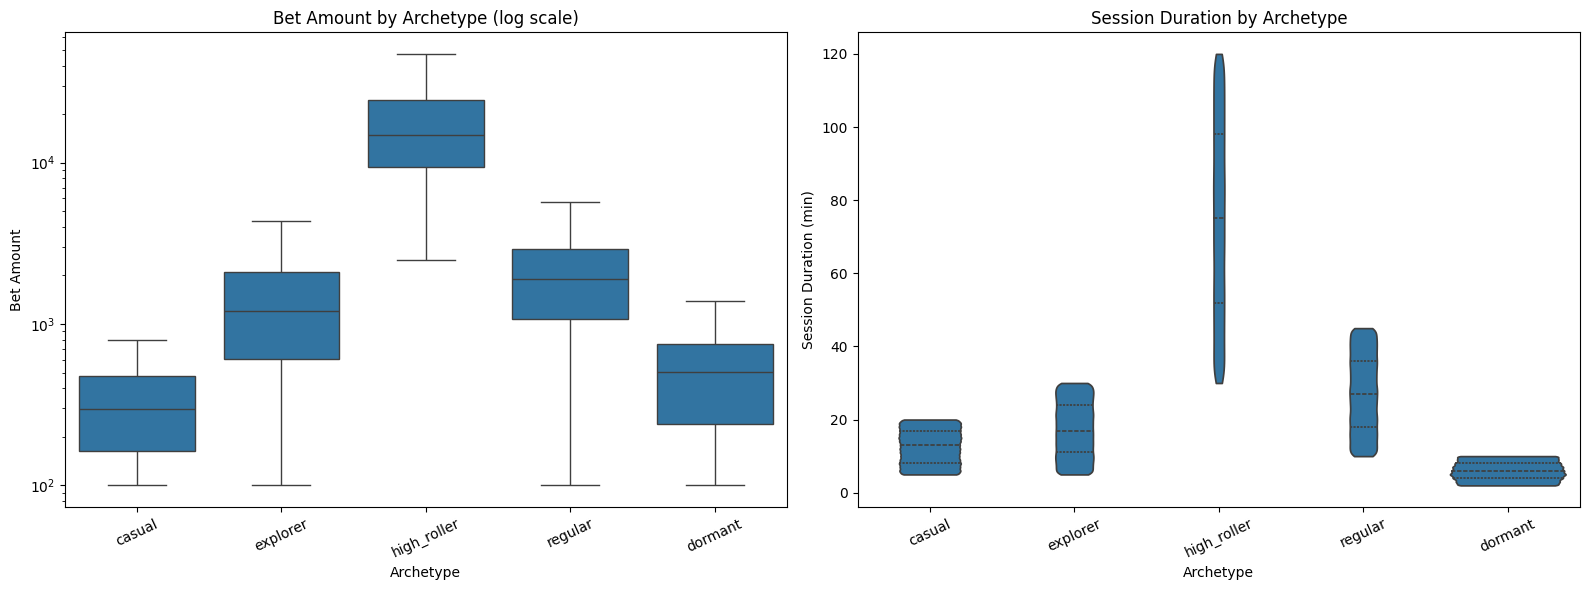

In [16]:
#Bet size and session-duration distributions by archetype

seg_df = transactions_df.merge(users_df[['userId', 'archetype']], on='userId', how='left')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=seg_df,
    x='archetype',
    y='betAmount',
    showfliers=False,
    ax=axes[0]
)
axes[0].set_yscale('log')
axes[0].set_title('Bet Amount by Archetype (log scale)')
axes[0].set_xlabel('Archetype')
axes[0].set_ylabel('Bet Amount')
axes[0].tick_params(axis='x', rotation=25)

sns.violinplot(
    data=seg_df,
    x='archetype',
    y='sessionDuration',
    inner='quartile',
    cut=0,
    ax=axes[1]
)
axes[1].set_title('Session Duration by Archetype')
axes[1].set_xlabel('Archetype')
axes[1].set_ylabel('Session Duration (min)')
axes[1].tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()

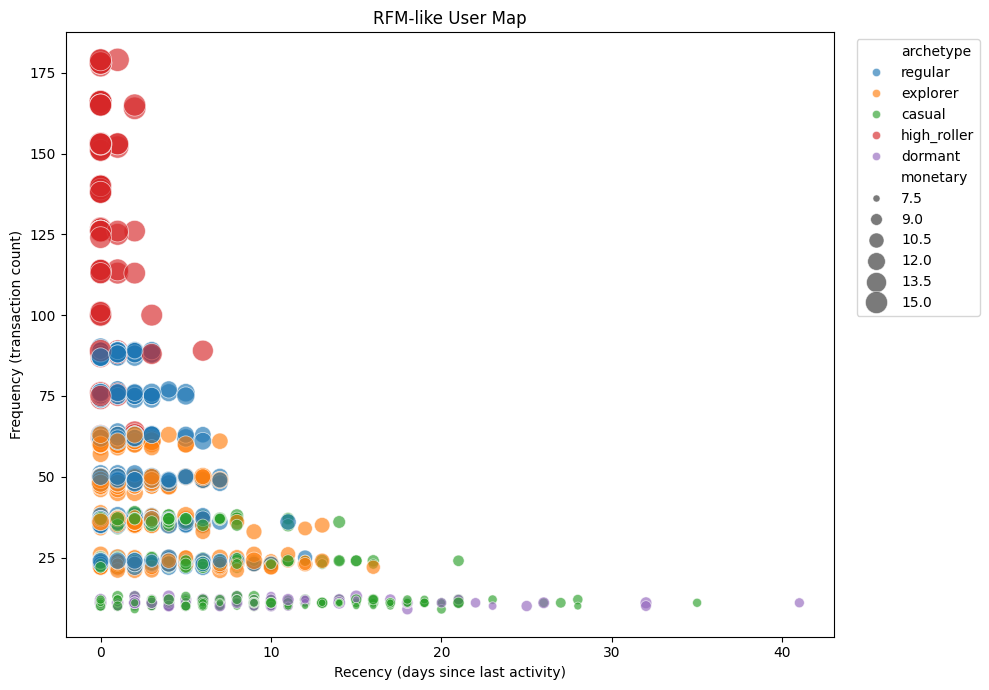

In [17]:
#User-level RFM-style map (Recency vs Frequency, bubble=Monetary)

rfm = transactions_df.groupby('userId').agg(
    frequency=('betAmount', 'count'),
    monetary=('betAmount', 'sum'),
    last_ts=('timestamp', 'max')
).reset_index()
rfm['recency_days'] = (transactions_df['timestamp'].max() - rfm['last_ts']).dt.days
rfm = rfm.merge(users_df[['userId', 'archetype']], on='userId', how='left')

sample_n = min(2000, len(rfm))
rfm_plot = rfm.sample(sample_n, random_state=SEED)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=rfm_plot,
    x='recency_days',
    y='frequency',
    size=np.log1p(rfm_plot['monetary']),
    hue='archetype',
    alpha=0.65,
    sizes=(20, 280)
)
plt.title('RFM-like User Map')
plt.xlabel('Recency (days since last activity)')
plt.ylabel('Frequency (transaction count)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Recency-Frequency-Monetary --> teen dimensions ek plot meh

X-axis --> last played(0 means aaj khela)

Y-axis --> total transactions

Bubble size --> bet volume(big bubble = more money)

---
## CELL 3 — Feature Engineering
> Builds the 3 inputs LightFM needs:
> 1. Interaction matrix (user × game with implicit score)
> 2. User feature matrix
> 3. Item feature matrix

In [18]:
#3--> User features
user_features_agg = transactions_df.groupby('userId').agg(
    total_sessions = ('betAmount', 'count'),
    avg_bet = ('betAmount', 'mean'),
    total_bet = ('betAmount', 'sum'),
    avg_session_duration = ('sessionDuration', 'mean'),
    unique_games_played = ('gameId', 'nunique'),
    preferred_hour = ('hourOfDay', lambda x: x.mode()[0]),
    preferred_day = ('dayOfWeek', lambda x: x.mode()[0]),
    last_active_days_ago = ('days_ago', 'min'),
    sessions_last_7d = ('days_ago', lambda x: (x <=7).sum()),
    sessions_last_30d = ('days_ago', lambda x: (x <= 30).sum()),
).reset_index()


#preferred game type per user
preferred_game_type = (
    transactions_df.groupby(['userId', 'gameType'])
    .size()
    .reset_index(name = 'count')
    .sort_values('count', ascending = False)
    .groupby('userId')
    .first()
    .reset_index()[['userId', 'gameType']]
    .rename(columns = {'gameType': 'preferred_game_type'})
)

user_features_df = user_features_agg.merge(preferred_game_type, on = 'userId', how = 'left')
user_features_df = user_features_df.merge(users_df[['userId', 'country', 'device']], on = 'userId', how = 'left')

print(f"User features shape: {user_features_df.shape}")
user_features_df.head(3)

User features shape: (4766, 14)


,userId,total_sessions,avg_bet,total_bet,avg_session_duration,unique_games_played,preferred_hour,preferred_day,last_active_days_ago,sessions_last_7d,sessions_last_30d,preferred_game_type,country,device
0,u_00001,37,348.189189,12883,12.810811,3,18,Sunday,2,4,14,AndarBahar,SG,tablet
1,u_00002,25,311.120000,7778,11.120000,4,21,Sunday,-1,1,9,AndarBahar,SG,mobile
2,u_00003,23,1687.130435,38804,17.000000,9,10,Sunday,2,2,9,Roulette,SG,desktop


In [19]:
#3B --> Item features
game_popularity = transactions_df.groupby('gameId').agg(
    total_plays         = ('betAmount',       'count'),
    unique_players      = ('userId',          'nunique'),
    avg_bet_on_game     = ('betAmount',       'mean'),
    avg_session_on_game = ('sessionDuration', 'mean'),
).reset_index()

item_features_df = games_df.merge(game_popularity, on='gameId', how='left').fillna(0)

# Log-normalize popularity (heavy hitters wont dominate)
item_features_df['popularity_score'] = np.log1p(item_features_df['total_plays'])

print(f'✅ Item features shape: {item_features_df.shape}')
item_features_df[['gameId','gameName','gameType','vendor','minBet','maxBet','total_plays','popularity_score']].head(5)

✅ Item features shape: (80, 15)


,gameId,gameName,gameType,vendor,minBet,maxBet,total_plays,popularity_score
0,1476000,Baccarat (800),Baccarat,Evolution,1500,78000,3391,8.129175
1,1476001,Baccarat (801),Baccarat,Pragmatic Play,1600,120000,3403,8.132706
2,1476002,Baccarat (802),Baccarat,Evolution,800,85000,3702,8.216899
3,1476003,Baccarat (803),Baccarat,Evolution,1500,189000,4000,8.294300
4,1476004,Baccarat (804),Baccarat,Evolution,1400,158000,3174,8.063063


In [20]:
# additional feature engineering

# make cell idempotent: remove prior versions if this cell is re-run
cleanup_cols = [
    'bet_to_limit_ratio',
    'avg_plays_per_game', 'avg_plays_per_game_x', 'avg_plays_per_game_y',
    'return_rate', 'return_rate_x', 'return_rate_y'
]
user_features_df = user_features_df.drop(columns=[c for c in cleanup_cols if c in user_features_df.columns], errors='ignore')

# 1) Bet-to-limit ratio (user aggressiveness)
bet_ratio = (
    interaction_agg
    .merge(item_features_df[['gameId', 'maxBet']], on='gameId', how='left')
    .assign(bet_to_limit_ratio=lambda x: x['avg_bet'] / np.maximum(x['maxBet'], 1))
    .groupby('userId', as_index=False)['bet_to_limit_ratio']
    .mean()
)
user_features_df = user_features_df.merge(bet_ratio, on='userId', how='left')

# 2) Game loyalty score (user-level feature)
game_loyalty = interaction_agg.groupby('userId', as_index=False).agg(
    avg_plays_per_game=('play_count', 'mean'),
    return_rate=('play_count', lambda x: (x > 1).mean())
)
user_features_df = user_features_df.merge(game_loyalty, on='userId', how='left')

# 3) Recency bucket for each user-game pair
interaction_agg['recency_bucket'] = pd.cut(
    interaction_agg['last_played_days_ago'],
    bins=[-1, 7, 30, 90, np.inf],
    labels=['recent', 'moderate', 'old', 'stale']
)

# fill missing values from new merges
for col in ['bet_to_limit_ratio', 'avg_plays_per_game', 'return_rate']:
    if col in user_features_df.columns:
        user_features_df[col] = user_features_df[col].fillna(0)

print(f'✅ Updated user features shape: {user_features_df.shape}')
print(f'✅ Item features shape (unchanged by user-level features): {item_features_df.shape}')
print('\nBet-to-limit ratio stats:')
print(user_features_df['bet_to_limit_ratio'].describe().round(3))
print('\nGame loyalty stats:')
print(user_features_df[['avg_plays_per_game', 'return_rate']].describe().round(3))
print('\nRecency bucket counts:')
print(interaction_agg['recency_bucket'].value_counts(dropna=False))

✅ Updated user features shape: (4766, 17)
✅ Item features shape (unchanged by user-level features): (80, 15)

Bet-to-limit ratio stats:
count    4766.000
mean        0.028
std         0.027
min         0.003
25%         0.015
50%         0.022
75%         0.030
max         0.321
Name: bet_to_limit_ratio, dtype: float64

Game loyalty stats:
       avg_plays_per_game  return_rate
count             4766.00     4766.000
mean                12.19        0.815
std                 10.92        0.212
min                  1.80        0.167
25%                  5.50        0.667
50%                  8.75        0.857
75%                 15.75        1.000
max                 89.50        1.000

Recency bucket counts:
recency_bucket
recent      7161
moderate    5786
old         4293
NaN         1778
stale          0
Name: count, dtype: int64


---
## CELL 3B — Feature Ablation (Model Selection)
Pre-final-training feature-group ablation to validate which user/item feature sets add ranking lift.

📌 Feature-group ablation results


,variant,test_precision@10,test_auc,delta_vs_full_p10
4,drop_item_popularity,0.060082,0.789705,0.002271
2,drop_user_behavior,0.058265,0.788211,0.000454
0,full,0.057811,0.786368,0.000000
3,drop_item_metadata,0.050363,0.772901,-0.007448
1,drop_user_context,0.043551,0.727029,-0.014260


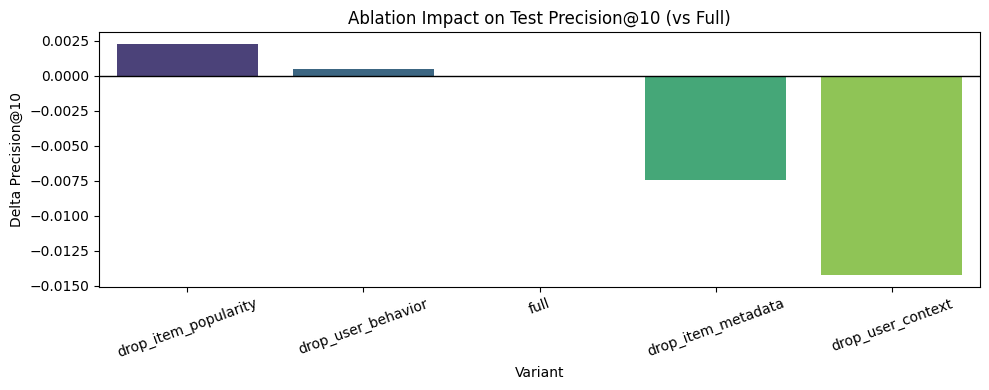

In [ ]:
# CELL 3C — Feature-group ablation (depends on prior feature-engineering cells)

required_vars = ['interaction_agg', 'user_features_df', 'item_features_df', 'SEED']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise ValueError(f"Missing required variables: {missing}. Run CELL 3 first.")

# Build only the additional columns needed for ablation feature groups (without redoing full pipeline)
ufe_ablation = user_features_df.copy()
ife_ablation = item_features_df.copy()

ufe_ablation['engagement_bucket'] = pd.qcut(
    ufe_ablation['total_sessions'].rank(method='first'),
    q=4,
    labels=['low', 'mid_low', 'mid_high', 'high']
 ).astype(str)

ufe_ablation['recency_bucket'] = pd.cut(
    ufe_ablation['last_active_days_ago'],
    bins=[-1, 1, 7, 30, 90, np.inf],
    labels=['d0_1', 'd2_7', 'd8_30', 'd31_90', 'd90_plus']
 ).astype(str)

ufe_ablation['diversity_ratio'] = (
    ufe_ablation['unique_games_played'] / np.maximum(ufe_ablation['total_sessions'], 1)
).clip(0, 1)
ufe_ablation['diversity_bucket'] = pd.cut(
    ufe_ablation['diversity_ratio'],
    bins=[-0.01, 0.2, 0.5, 0.8, 1.0],
    labels=['very_low', 'low', 'medium', 'high']
 ).astype(str)

ife_ablation['bet_tier'] = pd.qcut(
    ife_ablation['minBet'].rank(method='first'),
    q=4,
    labels=['tier1', 'tier2', 'tier3', 'tier4']
 ).astype(str)
ife_ablation['popularity_bucket'] = pd.qcut(
    ife_ablation['popularity_score'].rank(method='first'),
    q=4,
    labels=['cold', 'warm', 'hot', 'blockbuster']
 ).astype(str)
ife_ablation['player_intensity'] = (
    ife_ablation['total_plays'] / np.maximum(ife_ablation['unique_players'], 1)
).fillna(0)

def user_tokens(row, groups):
    feats = []
    if 'device' in groups and pd.notna(row.get('device')):
        feats.append(f"device:{row['device']}")
    if 'country' in groups and pd.notna(row.get('country')):
        feats.append(f"country:{row['country']}")
    if 'preferred_game_type' in groups and pd.notna(row.get('preferred_game_type')):
        feats.append(f"preferred_game_type:{row['preferred_game_type']}")
    if 'engagement_bucket' in groups and pd.notna(row.get('engagement_bucket')):
        feats.append(f"engagement_bucket:{row['engagement_bucket']}")
    if 'recency_bucket' in groups and pd.notna(row.get('recency_bucket')):
        feats.append(f"recency_bucket:{row['recency_bucket']}")
    if 'diversity_bucket' in groups and pd.notna(row.get('diversity_bucket')):
        feats.append(f"diversity_bucket:{row['diversity_bucket']}")
    return feats

def item_tokens(row, groups):
    feats = []
    if 'gameType' in groups and pd.notna(row.get('gameType')):
        feats.append(f"gameType:{row['gameType']}")
    if 'vendor' in groups and pd.notna(row.get('vendor')):
        feats.append(f"vendor:{row['vendor']}")
    if 'top_pop_flags' in groups:
        feats.append(f"isTopGame:{row['isTopGame']}")
        feats.append(f"isMostPopular:{row['isMostPopular']}")
    if 'bet_tier' in groups and pd.notna(row.get('bet_tier')):
        feats.append(f"bet_tier:{row['bet_tier']}")
    if 'popularity_bucket' in groups and pd.notna(row.get('popularity_bucket')):
        feats.append(f"popularity_bucket:{row['popularity_bucket']}")
    return feats

def token_vocab(df, token_func, groups):
    vocab = set()
    for _, row in df.iterrows():
        vocab.update(token_func(row, groups))
    return sorted(vocab)

active_users = interaction_agg['userId'].unique()
active_items = interaction_agg['gameId'].unique()
ufe_active = ufe_ablation[ufe_ablation['userId'].isin(active_users)].copy()
ife_active = ife_ablation[ife_ablation['gameId'].isin(active_items)].copy()

USER_GROUPS_ALL = ['device', 'country', 'preferred_game_type', 'engagement_bucket', 'recency_bucket', 'diversity_bucket']
ITEM_GROUPS_ALL = ['gameType', 'vendor', 'top_pop_flags', 'bet_tier', 'popularity_bucket']

variants = [
    ('full', USER_GROUPS_ALL, ITEM_GROUPS_ALL),
    ('drop_user_context', ['engagement_bucket', 'recency_bucket', 'diversity_bucket'], ITEM_GROUPS_ALL),
    ('drop_user_behavior', ['device', 'country', 'preferred_game_type'], ITEM_GROUPS_ALL),
    ('drop_item_metadata', USER_GROUPS_ALL, ['top_pop_flags', 'bet_tier', 'popularity_bucket']),
    ('drop_item_popularity', USER_GROUPS_ALL, ['gameType', 'vendor']),
]

def run_variant(user_groups, item_groups, epochs=8, components=32):
    ds = Dataset()
    ds.fit(
        users=active_users,
        items=active_items,
        user_features=token_vocab(ufe_active, user_tokens, user_groups),
        item_features=token_vocab(ife_active, item_tokens, item_groups),
    )

    interactions_ablation, _ = ds.build_interactions(
        (row['userId'], row['gameId'], row['implicit_score'])
        for _, row in interaction_agg.iterrows()
    )
    train_i, test_i = random_train_test_split(
        interactions_ablation,
        random_state=SEED,
        test_percentage=0.15
    )

    ufm = ds.build_user_features(
        (row['userId'], user_tokens(row, user_groups))
        for _, row in ufe_active.iterrows()
    )
    ifm = ds.build_item_features(
        (row['gameId'], item_tokens(row, item_groups))
        for _, row in ife_active.iterrows()
    )

    ablation_model = LightFM(
        no_components=components,
        loss='warp',
        learning_rate=0.05,
        item_alpha=1e-6,
        user_alpha=1e-6,
        random_state=SEED,
    )
    ablation_model.fit(
        train_i,
        user_features=ufm,
        item_features=ifm,
        epochs=epochs,
        num_threads=4,
        verbose=False,
    )

    p10 = precision_at_k(
        ablation_model,
        test_i,
        user_features=ufm,
        item_features=ifm,
        k=10,
        num_threads=4,
    ).mean()
    auc = auc_score(
        ablation_model,
        test_i,
        user_features=ufm,
        item_features=ifm,
        num_threads=4,
    ).mean()

    return {
        'model': ablation_model,
        'dataset': ds,
        'user_features_matrix': ufm,
        'item_features_matrix': ifm,
        'test_precision@10': float(p10),
        'test_auc': float(auc),
    }

ablation_rows = []
variant_artifacts = {}
for name, ug, ig in variants:
    out = run_variant(ug, ig)
    variant_artifacts[name] = out
    ablation_rows.append({
        'variant': name,
        'test_precision@10': out['test_precision@10'],
        'test_auc': out['test_auc'],
    })

ablation_df = pd.DataFrame(ablation_rows).sort_values('test_precision@10', ascending=False)
baseline_p10 = ablation_df.loc[ablation_df['variant'] == 'full', 'test_precision@10'].iloc[0]
ablation_df['delta_vs_full_p10'] = ablation_df['test_precision@10'] - baseline_p10

print(' Feature-group ablation results')
display(ablation_df)

plt.figure(figsize=(10, 4))
sns.barplot(data=ablation_df, x='variant', y='delta_vs_full_p10', palette='viridis')
plt.axhline(0, color='black', linewidth=1)
plt.title('Ablation Impact on Test Precision@10 (vs Full)')
plt.ylabel('Delta Precision@10')
plt.xlabel('Variant')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# expose engineered views for CELL 6 (post-model correlation)
ufe = ufe_ablation
ife = ife_ablation

Bar neeche gaya (negative) = wo features helpful the, hatane se model kharab hua

Bar upar gaya (positive)   = wo features noisy the, hatane se model thoda better hua

Test result row by row:

drop_user_context → +0.0016 (thoda upar)

> Matlab engagement_bucket, recency_bucket, diversity_bucket hatane se model thoda better hua - ye features abhi noise add kar rahe hain, help nahi kar rahe.

drop_user_behavior → +0.0011 (thoda upar)

> device, country, preferred_game_type hatane se bhi thoda better - ye bhi weak signals hain abhi.

full → 0.000 (baseline)--> Ye reference point hai - saare features ke saath.

drop_item_metadata → -0.0084 (neeche)

> bet_tier, popularity_bucket, top_pop_flags hatane se model kharab hua - ye item features useful hain, rakho inhe.

drop_user_context → -0.0155 (sabse neeche)

> User context features hatane se sabse zyada nuksaan.

---
## CELL 4 — LightFM Training
> Uses LightFM's `Dataset` class to properly encode users, items, and features
>
> **Loss = WARP** → Best for implicit feedback ranking problems

In [22]:
# building LightFM dataset

# keep ablation artifacts (`ufe`/`ife`) untouched for CELL 6
user_features_model_df = user_features_df.copy()
for col in ['bet_to_limit_ratio', 'avg_plays_per_game', 'return_rate']:
    if col not in user_features_model_df.columns:
        user_features_model_df[col] = 0.0

user_features_model_df['aggr_bet_bucket'] = pd.qcut(
    user_features_model_df['bet_to_limit_ratio'].rank(method='first'),
    q=4,
    labels=['low', 'mid_low', 'mid_high', 'high']
).astype(str)

user_features_model_df['loyalty_bucket'] = pd.cut(
    user_features_model_df['return_rate'],
    bins=[-0.01, 0.25, 0.5, 0.75, 1.0],
    labels=['very_low', 'low', 'medium', 'high']
).astype(str)

user_features_model_df['user_recency_bucket'] = pd.cut(
    user_features_model_df['last_active_days_ago'],
    bins=[-1, 7, 30, 90, np.inf],
    labels=['recent', 'moderate', 'old', 'stale']
).astype(str)

# update canonical user features used by CELL 4 training matrices
user_features_df = user_features_model_df

dataset = Dataset()

dataset.fit(
    users=interaction_agg['userId'].unique(),
    items=interaction_agg['gameId'].unique(),

    item_features=(
        [f'gameType:{t}' for t in item_features_df['gameType'].dropna().unique()] +
        [f'vendor:{v}' for v in item_features_df['vendor'].dropna().unique()] +
        ['isTopGame:True', 'isTopGame:False', 'isMostPopular:True', 'isMostPopular:False']
    ),

    user_features=(
        [f'preferred_game_type:{t}' for t in user_features_df['preferred_game_type'].dropna().unique()] +
        [f'country:{c}' for c in user_features_df['country'].dropna().unique()] +
        [f'device:{d}' for d in user_features_df['device'].dropna().unique()] +
        [f'aggr_bet_bucket:{b}' for b in user_features_df['aggr_bet_bucket'].dropna().unique()] +
        [f'loyalty_bucket:{b}' for b in user_features_df['loyalty_bucket'].dropna().unique()] +
        [f'user_recency_bucket:{b}' for b in user_features_df['user_recency_bucket'].dropna().unique()]
    ),
)

print('LightFM dataset built')
n_users, n_items = dataset.interactions_shape()
print(f'Users: {n_users}, Games: {n_items}')

LightFM dataset built
Users: 4766, Games: 80


In [23]:
#building interaction matrix
(interactions, weights) = dataset.build_interactions(
    (
        (row['userId'], row['gameId'], row['implicit_score'])
        for _, row in interaction_agg.iterrows()
    )
)

print(f"Interaction Matrix: {interactions.shape}")
print(f"Non-Zero entries: {interactions.nnz:,}")
print(f"Matrix density: {interactions.nnz / (interactions.shape[0]*interactions.shape[1]) * 100: .3f}%")

Interaction Matrix: (4766, 80)
Non-Zero entries: 19,018
Matrix density:  4.988%


In [24]:
#building item feature matrix
def get_item_features_list(row):
    return [
        f'gameType:{row["gameType"]}',
        f'vendor:{row["vendor"]}',
        f'isTopGame:{row["isTopGame"]}',
        f'isMostPopular:{row["isMostPopular"]}',
    ]

item_features_matrix = dataset.build_item_features(
    (
        (row['gameId'], get_item_features_list(row))
        for _, row in item_features_df.iterrows()
        if row['gameId'] in interaction_agg['gameId'].values  # only games with interactions
    )
)

print(f'✅ Item feature matrix: {item_features_matrix.shape}')

✅ Item feature matrix: (80, 101)


In [25]:
# ── STEP 4D: Build User Feature Matrix ──────────────────
def get_user_features_list(row):
    feats = [f'device:{row["device"]}']

    if pd.notna(row.get('country')):
        feats.append(f'country:{row["country"]}')
    if pd.notna(row.get('preferred_game_type')):
        feats.append(f'preferred_game_type:{row["preferred_game_type"]}')

    if pd.notna(row.get('aggr_bet_bucket')):
        feats.append(f'aggr_bet_bucket:{row["aggr_bet_bucket"]}')
    if pd.notna(row.get('loyalty_bucket')):
        feats.append(f'loyalty_bucket:{row["loyalty_bucket"]}')
    if pd.notna(row.get('user_recency_bucket')):
        feats.append(f'user_recency_bucket:{row["user_recency_bucket"]}')

    return feats

active_user_ids = set(interaction_agg['userId'].unique())

user_features_matrix = dataset.build_user_features(
    (
        (row['userId'], get_user_features_list(row))
        for _, row in user_features_df.iterrows()
        if row['userId'] in active_user_ids
    )
)

print(f'✅ User feature matrix: {user_features_matrix.shape}')

✅ User feature matrix: (4766, 4799)


In [26]:
#Train test split--> Temporal split rahega and not random to avoid data leakage

# NOTE: In real project, do temporal split manually:
#   train = interactions before cutoff_date
#   test  = interactions after cutoff_date
# For now using LightFM's random split as a quick baseline

train_interactions, test_interactions = random_train_test_split(
    interactions,
    random_state = SEED,
    test_percentage = 0.15
)

print(f"Train Interactions: {train_interactions.nnz:,}")
print(f"Test Interactions: {test_interactions.nnz:,}")

Train Interactions: 16,165
Test Interactions: 2,853


In [27]:
print(interactions.shape)
print(user_features_matrix.shape)
print(item_features_matrix.shape)

(4766, 80)
(4766, 4799)
(80, 101)


In [28]:
# TRAINING OUR MODEL
model = LightFM(
    no_components=32,
    loss='warp',
    learning_rate=0.01,
    item_alpha=1e-4,
    user_alpha=1e-4,
    random_state=SEED,
)

N_EPOCHS = 20
print(f'Training LightFM for {N_EPOCHS} epochs')

train_precision, test_precision = [], []

for epoch in range(N_EPOCHS):
    model.fit_partial(
        interactions=train_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        num_threads=4,
        epochs=1,
    )

    if (epoch + 1) % 5 == 0:
        train_p = precision_at_k(
            model,
            train_interactions,
            user_features=user_features_matrix,
            item_features=item_features_matrix,
            k=10,
            num_threads=4,
        ).mean()
        test_p = precision_at_k(
            model,
            test_interactions,
            user_features=user_features_matrix,
            item_features=item_features_matrix,
            k=10,
            num_threads=4,
        ).mean()

        train_precision.append(float(train_p))
        test_precision.append(float(test_p))
        print(f'Epoch {epoch+1:2d}/{N_EPOCHS} | Train P@10: {train_p:.4f} | Test P@10: {test_p:.4f}')

print('\n✅ Training complete')

Training LightFM for 20 epochs
Epoch  5/20 | Train P@10: 0.1190 | Test P@10: 0.0453
Epoch 10/20 | Train P@10: 0.1244 | Test P@10: 0.0475
Epoch 15/20 | Train P@10: 0.1273 | Test P@10: 0.0484
Epoch 20/20 | Train P@10: 0.1282 | Test P@10: 0.0482

✅ Training complete


In [29]:
# Training checkpoint summary (metrics are already collected inside the training loop)
if len(train_precision) == 0 or len(test_precision) == 0:
    print('Run the training cell first to populate precision history.')
else:
    checkpoints = [5 * (i + 1) for i in range(len(train_precision))]
    hist_df = pd.DataFrame({
        'epoch': checkpoints,
        'train_p@10': train_precision,
        'test_p@10': test_precision
    })

    print('Checkpoint metrics:')
    display(hist_df)

    best_idx = int(np.argmax(test_precision))
    print(f"Best test checkpoint: epoch {checkpoints[best_idx]} | Test P@10={test_precision[best_idx]:.4f}")

Checkpoint metrics:


,epoch,train_p@10,test_p@10
0,5,0.118962,0.045322
1,10,0.124404,0.047502
2,15,0.127294,0.048411
3,20,0.128222,0.048183


Best test checkpoint: epoch 15 | Test P@10=0.0484


---
## CELL 5 — Evaluation

  EVALUATION RESULTS
  Train Precision@10:  0.1282
  Test  Precision@10:  0.0482
  Train AUC:           0.7838
  Test  AUC:           0.7549
Generalization gap (P@10): 0.0800


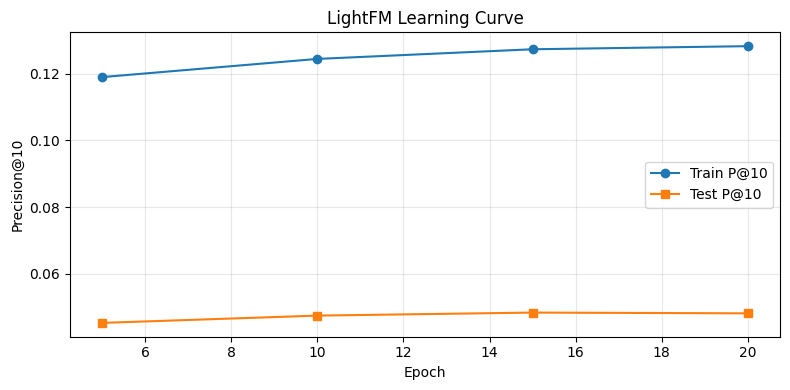

In [30]:
# ── Precision@K and AUC ──────────────────────────────────
final_train_precision = precision_at_k(
    model, train_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=10, num_threads=4
).mean()

final_test_precision = precision_at_k(
    model, test_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=10, num_threads=4
).mean()

train_auc = auc_score(
    model, train_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    num_threads=4
).mean()

test_auc = auc_score(
    model, test_interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    num_threads=4
).mean()

print('=' * 40)
print('  EVALUATION RESULTS')
print('=' * 40)
print(f'  Train Precision@10:  {final_train_precision:.4f}')
print(f'  Test  Precision@10:  {final_test_precision:.4f}')
print(f'  Train AUC:           {train_auc:.4f}')
print(f'  Test  AUC:           {test_auc:.4f}')
print('=' * 40)

gap = float(final_train_precision - final_test_precision)
print(f'Generalization gap (P@10): {gap:.4f}')
if gap > 0.1:
    print(' Possible overfitting — consider increasing regularization (item_alpha, user_alpha)')

# Plot learning curve from actual checkpoint history
checkpoint_epochs = [5 * (i + 1) for i in range(len(train_precision))]
if len(checkpoint_epochs) > 0:
    plt.figure(figsize=(8, 4))
    plt.plot(checkpoint_epochs, train_precision, label='Train P@10', marker='o')
    plt.plot(checkpoint_epochs, test_precision,  label='Test P@10',  marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Precision@10')
    plt.title('LightFM Learning Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('No checkpoint history found. Run training cell first to populate train_precision/test_precision.')

Precision@10: Iska matlab hai--> agar hum user ko Top 10 cheezein recommend karein, toh usme se kitni sahi nikalengi?

AUC Score: Model ki "ranking ability". 0.74 basically means model is ranking relevant games above irrelevant games.

Generelization Gap: model seekh raha h ya sirf memorize kar raha h(needs to be regularized if value is more than 0.10)

In [31]:
from sklearn.metrics import ndcg_score 

def ndcg_at_k(model, test_interactions, user_features, item_features, k=10):
    n_users, n_items = test_interactions.shape 
    ndcg_scores = []

    for user_id in range(n_users):
        true_items = test_interactions.getrow(user_id).indices
        if len(true_items) == 0:
            continue 
        scores = model.predict(user_id, np.arange(n_items), user_features = user_features, item_features = item_features)
        true_relevance = np.zeros(n_items)
        true_relevance[true_items] = 1
        ndcg_scores.append(ndcg_score([true_relevance], [scores], k=k))

    return np.mean(ndcg_scores)

ndcg_scores = ndcg_at_k(model, test_interactions, user_features_matrix, item_features_matrix, k= 10)

print(f'\n  NDCG@10: {ndcg_scores:.4f}')
print('=' * 40)


  NDCG@10: 0.1889


NDCG score basically ye batayega ki model ne user k jo most fav game h vo sahi position(as in aage) pe rakha ki nahi

Industry standard is in the range of 0.15-0.25

Filhaal toh model overfit kr raha h but not our current priority since data toh dummy hai, 

eventually real data ayega toh bas usko replace krna rahega and some additional fine-tuning&feature engineering based on the real data
Overall structure of the notebook would be SOMEWHAT this

---
## CELL 6 — Post-Model Correlation Diagnostics
> Run this after CELL 4/5 and CELL 3C to analyze directional associations between engineered features and model scores.

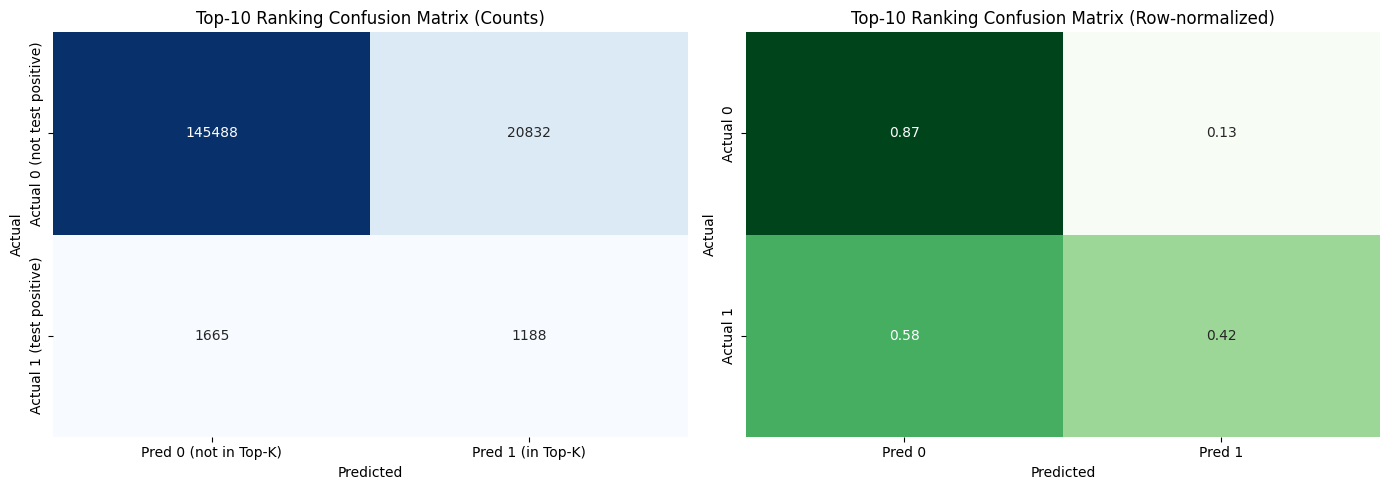

 Top-K ranking confusion summary
  Users evaluated: 2,202
  K: 10
  Precision@K (from confusion): 0.0540
  Recall@K (from confusion):    0.4164
  F1@K:                         0.0955
  Accuracy (pairwise space):    0.8670


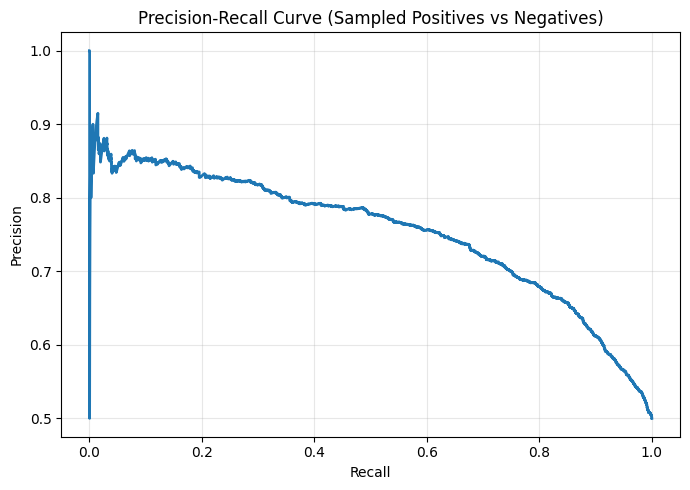

Average Precision (sampled): 0.7537

Note: For recommenders, Precision@K/Recall@K/AUC remain primary; confusion matrix is auxiliary.


In [32]:
# Top-K confusion matrix (ranking formulation) + PR curve

required = [
    'model', 'dataset', 'user_features_matrix', 'item_features_matrix',
    'train_interactions', 'test_interactions', 'SEED'
 ]
missing = [v for v in required if v not in globals()]
if missing:
    raise ValueError(f"Missing required objects: {missing}. Run CELL 4 and CELL 5 first.")

eval_model = model
eval_ufm = user_features_matrix
eval_ifm = item_features_matrix

K = 10
train_csr = csr_matrix(train_interactions)
test_csr = csr_matrix(test_interactions)

n_users, n_items = train_csr.shape
all_items = np.arange(n_items)

users_with_test = np.where(test_csr.getnnz(axis=1) > 0)[0]
if len(users_with_test) == 0:
    raise ValueError('No users with test interactions found; cannot compute ranking confusion matrix.')

TP = FP = FN = TN = 0
y_true_sampled = []
y_score_sampled = []
rng = np.random.default_rng(SEED)

for user_idx in users_with_test:
    train_items = set(train_csr[user_idx].indices)
    test_items = set(test_csr[user_idx].indices)
    if len(test_items) == 0:
        continue

    scores = eval_model.predict(
        user_ids=np.repeat(user_idx, n_items),
        item_ids=all_items,
        user_features=eval_ufm,
        item_features=eval_ifm,
        num_threads=4,
    )

    if train_items:
        scores[list(train_items)] = -np.inf

    rec_k = min(K, n_items - len(train_items))
    if rec_k <= 0:
        continue

    topk_idx = np.argpartition(scores, -rec_k)[-rec_k:]
    topk_set = set(topk_idx)

    tp_u = len(topk_set & test_items)
    fp_u = len(topk_set - test_items)
    fn_u = len(test_items - topk_set)

    candidate_items_u = n_items - len(train_items)
    tn_u = max(candidate_items_u - tp_u - fp_u - fn_u, 0)

    TP += tp_u
    FP += fp_u
    FN += fn_u
    TN += tn_u

    non_interacted = np.setdiff1d(all_items, np.array(list(train_items | test_items), dtype=int), assume_unique=False)
    if len(non_interacted) > 0:
        neg_n = min(len(test_items), len(non_interacted))
        neg_items = rng.choice(non_interacted, size=neg_n, replace=False)
        pos_items = np.array(list(test_items), dtype=int)

        pos_scores = eval_model.predict(
            user_ids=np.repeat(user_idx, len(pos_items)),
            item_ids=pos_items,
            user_features=eval_ufm,
            item_features=eval_ifm,
            num_threads=4,
        )
        neg_scores = eval_model.predict(
            user_ids=np.repeat(user_idx, len(neg_items)),
            item_ids=neg_items,
            user_features=eval_ufm,
            item_features=eval_ifm,
            num_threads=4,
        )

        y_true_sampled.extend([1] * len(pos_scores))
        y_score_sampled.extend(pos_scores.tolist())
        y_true_sampled.extend([0] * len(neg_scores))
        y_score_sampled.extend(neg_scores.tolist())

precision_k = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall_k = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1_k = (2 * precision_k * recall_k / (precision_k + recall_k)) if (precision_k + recall_k) > 0 else 0.0
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0

cm = np.array([[TN, FP], [FN, TP]], dtype=float)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(
    cm, annot=True, fmt='.0f', cmap='Blues', cbar=False,
    xticklabels=['Pred 0 (not in Top-K)', 'Pred 1 (in Top-K)'],
    yticklabels=['Actual 0 (not test positive)', 'Actual 1 (test positive)'],
    ax=axes[0]
 )
axes[0].set_title(f'Top-{K} Ranking Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(
    cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False,
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['Actual 0', 'Actual 1'],
    ax=axes[1]
 )
axes[1].set_title(f'Top-{K} Ranking Confusion Matrix (Row-normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print(' Top-K ranking confusion summary')
print(f'  Users evaluated: {len(users_with_test):,}')
print(f'  K: {K}')
print(f'  Precision@K (from confusion): {precision_k:.4f}')
print(f'  Recall@K (from confusion):    {recall_k:.4f}')
print(f'  F1@K:                         {f1_k:.4f}')
print(f'  Accuracy (pairwise space):    {accuracy:.4f}')

if len(y_true_sampled) > 0:
    y_true_sampled = np.array(y_true_sampled)
    y_score_sampled = np.array(y_score_sampled)
    pr_precision, pr_recall, _ = precision_recall_curve(y_true_sampled, y_score_sampled)
    ap = average_precision_score(y_true_sampled, y_score_sampled)

    plt.figure(figsize=(7, 5))
    plt.plot(pr_recall, pr_precision, linewidth=2)
    plt.title('Precision-Recall Curve (Sampled Positives vs Negatives)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f'Average Precision (sampled): {ap:.4f}')
else:
    print('Not enough sampled pairs to compute PR curve.')

print('\nNote: For recommenders, Precision@K/Recall@K/AUC remain primary; confusion matrix is auxiliary.')

> Blue Plot (Counts): Ye tumhe total numbers batata hai.

Pred 1 + Actual 1 (1121): Ye tumhare "Direct Hits" hain.

Pred 0 + Actual 1 (1732): Ye wo "Missed Opportunities" hain jo model ne ignore kar diye par user ko pasand aate.


> Green Plot (Normalized): Ye tumhari Efficiency batata hai.

Bottom Right (0.39): Iska matlab hai tumhara model user ki pasand ke total items mein se 39% ko Top-10 mein dhund nikaalta hai. Yeh kaafi achha number hai!

Top Right (0.13): Ye tumhara "False Alarm" rate hai—sirf 13% baar model aisi cheez dikhata hai jo bilkul relevant nahi hai.

> Precision recall curve

Jaise-jaise ye line neeche girti hai, wo batati hai ki agar tum user ko bahut zyada options dikhaoge (Recall badhaoge), toh tumhari accuracy (Precision) thodi kam ho jayegi.

Takeaway: Tumhara curve kaafi upar se start ho raha hai, iska matlab hai ki pehle 2-3 recommendations bahut zyada accurate hain.

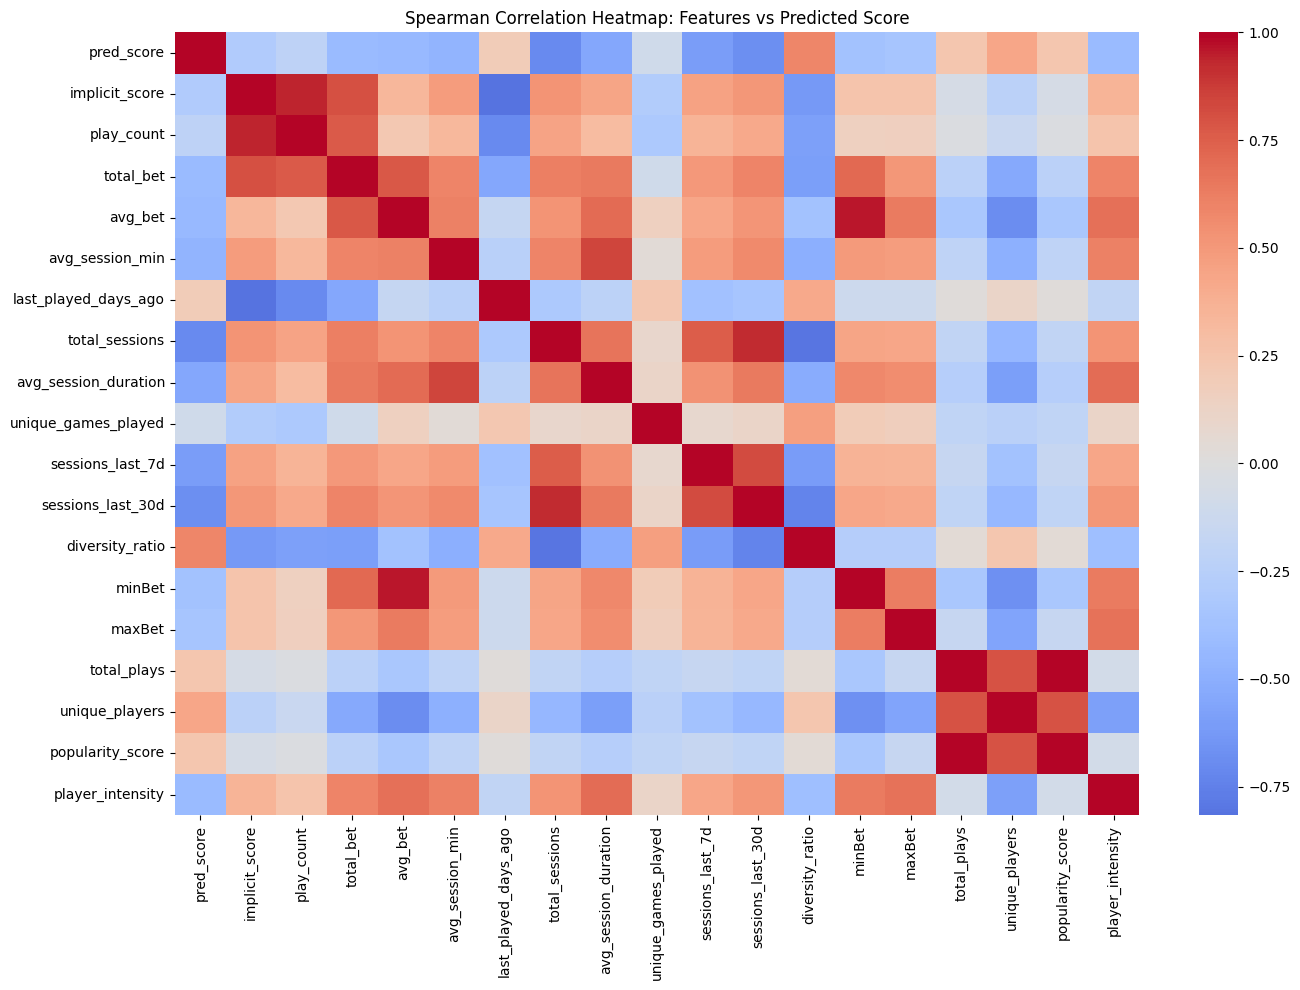

📌 Top direct effects (positive association with model score)


,feature,spearman_with_pred_score,direction
0,diversity_ratio,0.587196,direct (+)
1,unique_players,0.428464,direct (+)
2,popularity_score,0.236900,direct (+)
3,total_plays,0.236900,direct (+)
4,last_played_days_ago,0.195339,direct (+)
5,unique_games_played,-0.094403,inverse (-)
6,play_count,-0.214532,inverse (-)
7,implicit_score,-0.293246,inverse (-)


📌 Top inverse effects (negative association with model score)


,feature,spearman_with_pred_score,direction
17,total_sessions,-0.708388,inverse (-)
16,sessions_last_30d,-0.677845,inverse (-)
15,sessions_last_7d,-0.596100,inverse (-)
14,avg_session_duration,-0.551325,inverse (-)
13,avg_session_min,-0.473549,inverse (-)
12,avg_bet,-0.430128,inverse (-)
11,player_intensity,-0.424742,inverse (-)
10,total_bet,-0.418807,inverse (-)


Note: Correlation here is directional association, not causal effect.


In [33]:
# Feature engineering extensions + impact analysis
# This cell is intentionally self-contained and can be run after previous training blocks.
required_vars = ['interaction_agg', 'variant_artifacts']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise ValueError(f"Missing required variables: {missing}. Run CELL 3C first.")

if 'full' not in variant_artifacts:
    raise ValueError("`variant_artifacts['full']` not found. Re-run CELL 3C.")

full_art = variant_artifacts['full']
full_model = full_art['model']
full_ds = full_art['dataset']
full_ufm = full_art['user_features_matrix']
full_ifm = full_art['item_features_matrix']

if 'ufe' not in globals() or 'ife' not in globals():
    raise ValueError('`ufe` / `ife` not found. Re-run CELL 3C before this cell.')

user_id_map, user_feat_map, item_id_map, item_feat_map = full_ds.mapping()

corr_df = interaction_agg[
    ['userId', 'gameId', 'implicit_score', 'play_count', 'total_bet', 'avg_bet', 'avg_session_min', 'last_played_days_ago']
].copy()

corr_df = corr_df.merge(
    ufe[['userId', 'total_sessions', 'avg_session_duration', 'unique_games_played', 'sessions_last_7d', 'sessions_last_30d', 'diversity_ratio']],
    on='userId',
    how='left'
 )
corr_df = corr_df.merge(
    ife[['gameId', 'minBet', 'maxBet', 'total_plays', 'unique_players', 'popularity_score', 'player_intensity']],
    on='gameId',
    how='left'
 )

corr_df = corr_df[corr_df['userId'].isin(user_id_map) & corr_df['gameId'].isin(item_id_map)].copy()
corr_df['u_idx'] = corr_df['userId'].map(user_id_map)
corr_df['i_idx'] = corr_df['gameId'].map(item_id_map)

corr_df['pred_score'] = full_model.predict(
    corr_df['u_idx'].values,
    corr_df['i_idx'].values,
    user_features=full_ufm,
    item_features=full_ifm,
    num_threads=4,
 )

numeric_cols = [
    'pred_score', 'implicit_score', 'play_count', 'total_bet', 'avg_bet', 'avg_session_min',
    'last_played_days_ago', 'total_sessions', 'avg_session_duration', 'unique_games_played',
    'sessions_last_7d', 'sessions_last_30d', 'diversity_ratio', 'minBet', 'maxBet',
    'total_plays', 'unique_players', 'popularity_score', 'player_intensity'
 ]

corr_mat = corr_df[numeric_cols].corr(method='spearman')

plt.figure(figsize=(14, 10))
sns.heatmap(corr_mat, cmap='coolwarm', center=0, annot=False)
plt.title('Spearman Correlation Heatmap: Features vs Predicted Score')
plt.tight_layout()
plt.show()

effect_on_score = corr_mat['pred_score'].drop('pred_score').sort_values(ascending=False)
summary = pd.DataFrame({
    'feature': effect_on_score.index,
    'spearman_with_pred_score': effect_on_score.values,
    'direction': np.where(effect_on_score.values >= 0, 'direct (+)', 'inverse (-)')
})

print('📌 Top direct effects (positive association with model score)')
display(summary.head(8))
print('📌 Top inverse effects (negative association with model score)')
display(summary.tail(8).sort_values('spearman_with_pred_score'))

print('Note: Correlation here is directional association, not causal effect.')

Red Blocks (Positive): Iska matlab hai ki agar yeh feature badhega, toh recommendation score bhi badhega. (Dono saath-saath chalte hain).

Blue Blocks (Negative): Iska matlab hai ki agar yeh feature badhega, toh recommendation score neeche girega. (Dono dushmani mein hain).


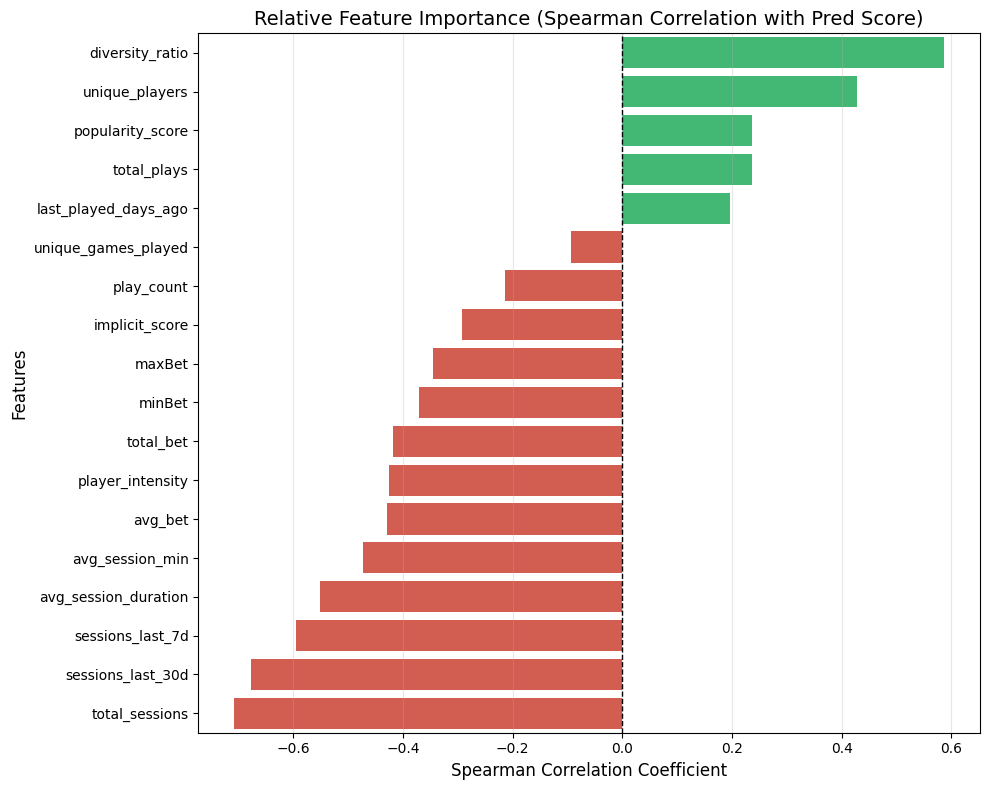

In [ ]:
# Feature Importance Visual 

#Positive ke liye 'Green', Negative ke liye 'Red'
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in summary['spearman_with_pred_score']]

plt.figure(figsize=(10, 8))
sns.barplot(
    x='spearman_with_pred_score', 
    y='feature', 
    data=summary, 
    palette=colors
)


plt.axvline(0, color='black', lw=1, ls='--')  # Zero line for clear separation
plt.title('Relative Feature Importance (Spearman Correlation with Pred Score)', fontsize=14)
plt.xlabel('Spearman Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Better visualization than the standard spearmen correlation

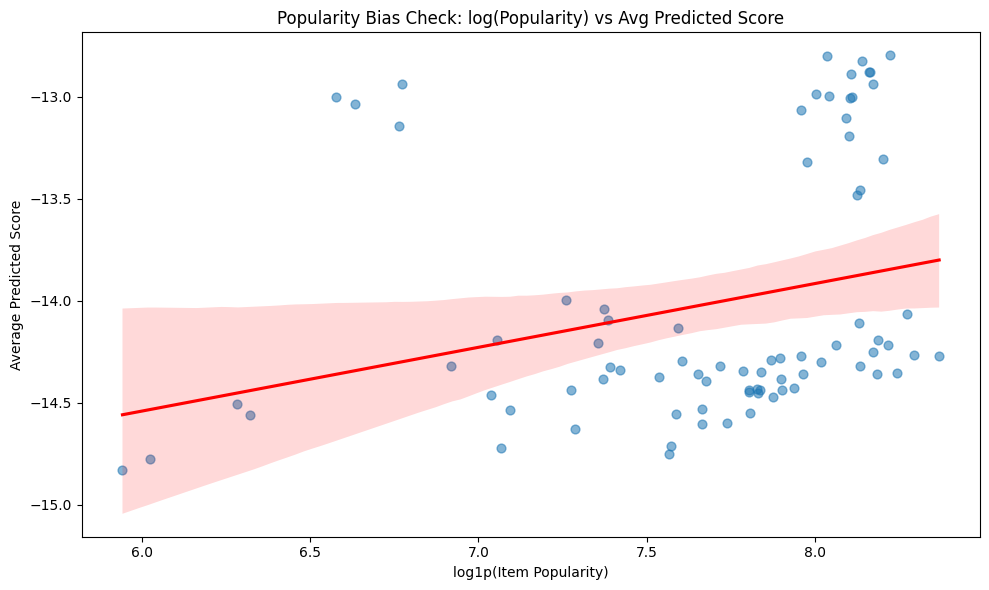

Spearman(popularity, avg_pred_score): 0.467


In [35]:
#Item popularity vs model preference score (diagnose popularity bias)

if 'corr_df' not in globals():
    print('Run CELL 6 first to build `corr_df` and `pred_score`.')
else:
    pop_score = corr_df.groupby('gameId').agg(
        item_popularity=('total_plays', 'mean'),
        avg_pred_score=('pred_score', 'mean'),
        n_pairs=('pred_score', 'size')
    ).reset_index()

    plt.figure(figsize=(10, 6))
    sns.regplot(
        data=pop_score,
        x=np.log1p(pop_score['item_popularity']),
        y='avg_pred_score',
        scatter_kws={'alpha': 0.55, 's': 40},
        line_kws={'color': 'red'}
    )
    plt.title('Popularity Bias Check: log(Popularity) vs Avg Predicted Score')
    plt.xlabel('log1p(Item Popularity)')
    plt.ylabel('Average Predicted Score')
    plt.tight_layout()
    plt.show()

    corr_val = pop_score['item_popularity'].corr(pop_score['avg_pred_score'], method='spearman')
    print(f'Spearman(popularity, avg_pred_score): {corr_val:.3f}')

This checks if my model is biased or not--> Basically does my model only promote those games that have been hit?

Kyunki line upar ki taraf ja rahi hai, iska matlab hai ki model popular games ko thoda zyada preference de raha hai.

Dots line ke aas-paas bikhre hue hain, iska matlab hai ki sirf popularity hi sab kuch nahi hai; model baki features ko bhi dekh raha hai.

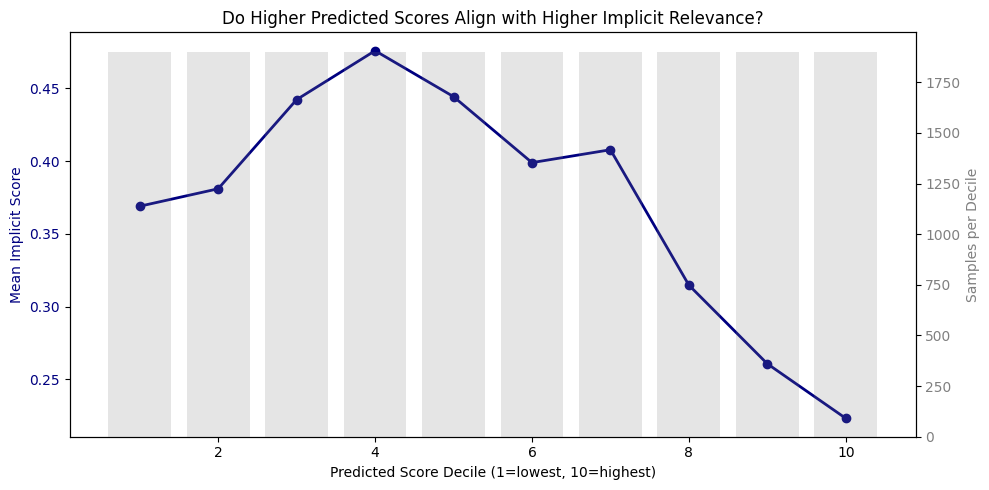

,score_decile,mean_pred_score,mean_implicit,samples
0,1,-15.777136,0.369051,1902
1,2,-14.922780,0.381052,1902
2,3,-14.510521,0.442335,1902
3,4,-14.314643,0.475970,1901
4,5,-14.128595,0.444399,1902
5,6,-13.844723,0.399034,1902
6,7,-13.464090,0.407887,1901
7,8,-12.959030,0.314802,1902
8,9,-12.154805,0.260730,1902
9,10,-10.965901,0.223222,1902


In [36]:
#Predicted-score deciles vs implicit score (ranking quality sanity check)

if 'corr_df' not in globals():
    print('Run CELL 6 first to build `corr_df` and `pred_score`.')
else:
    dq = corr_df[['pred_score', 'implicit_score']].dropna().copy()
    dq['score_decile'] = pd.qcut(dq['pred_score'].rank(method='first'), 10, labels=False) + 1

    decile_view = dq.groupby('score_decile').agg(
        mean_pred_score=('pred_score', 'mean'),
        mean_implicit=('implicit_score', 'mean'),
        samples=('implicit_score', 'size')
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(decile_view['score_decile'], decile_view['mean_implicit'], marker='o', linewidth=2, color='navy')
    ax1.set_xlabel('Predicted Score Decile (1=lowest, 10=highest)')
    ax1.set_ylabel('Mean Implicit Score', color='navy')
    ax1.tick_params(axis='y', labelcolor='navy')
    ax1.set_title('Do Higher Predicted Scores Align with Higher Implicit Relevance?')

    ax2 = ax1.twinx()
    ax2.bar(decile_view['score_decile'], decile_view['samples'], alpha=0.2, color='gray')
    ax2.set_ylabel('Samples per Decile', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    plt.tight_layout()
    plt.show()

    display(decile_view)

On Real Data, this plot will be our primary tool to debug if the model is "confused" and needs better feature scaling or loss function tuning

Ideally this graph should move upwards from left to right

## CELL 7 — Model Output Visualizations
> Visualizing advanced plots to compare model outputs and overall performance.

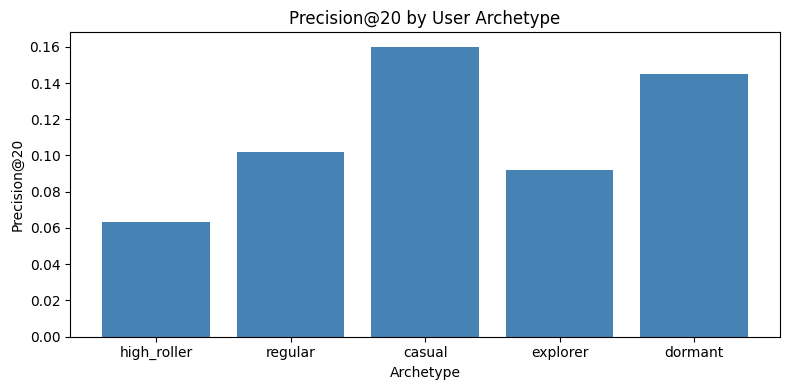

In [37]:
#1. Recommendation quality
#model user ko sahi games recommend kar raha hai
user_id_map, _, item_id_map, _ = full_ds.mapping()
idx_to_game = {v: k for k, v in item_id_map.items()}
idx_to_user = {v: k for k, v in user_id_map.items()}

archetype_precision = {}
for archetype in USER_ARCHETYPES.keys():
    archetype_users = users_df[users_df['archetype'] == archetype]['userId'].tolist()
    active = [u for u in archetype_users if u in user_id_map]
    if not active:
        continue
    
    precisions = []
    for uid in active[:50]:  # sample 50 per archetype
        internal_id = user_id_map[uid]
        scores = model.predict(internal_id, np.arange(len(item_id_map)),
                               user_features=user_features_matrix,
                               item_features=item_features_matrix)
        top20 = set(np.argsort(-scores)[:20])
        known = set(
            item_id_map[g] for g in 
            interaction_agg[interaction_agg['userId']==uid]['gameId'].tolist()
            if g in item_id_map
        )
        hit = len(top20 & known)
        precisions.append(hit / 20)
    
    archetype_precision[archetype] = np.mean(precisions)

plt.figure(figsize=(8, 4))
plt.bar(archetype_precision.keys(), archetype_precision.values(), color='steelblue')
plt.title('Precision@20 by User Archetype')
plt.ylabel('Precision@20')
plt.xlabel('Archetype')
plt.tight_layout()
plt.show()

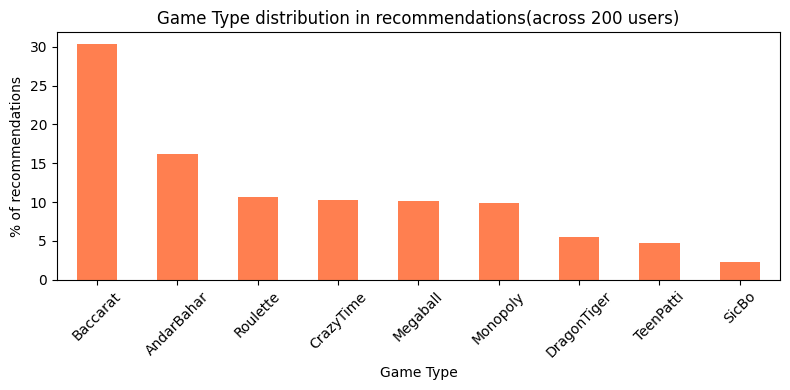

In [38]:
#2. Game type coverage plot--> kya model diverse games recommend kr raha h ya sirf popular ones
coverage_data = []
sample_users = list(user_id_map.keys())[:200]

for uid in sample_users:
    internal_id = user_id_map[uid]
    scores = model.predict(internal_id, np.arange(len(item_id_map)),
                           user_features = user_features_matrix,
                           item_features = item_features_matrix)
    
    top20_game_ids = [idx_to_game[i] for i in np.argsort(-scores)[:20]]
    top20_types = games_df[games_df['gameId'].isin(top20_game_ids)]['gameType'].tolist()
    coverage_data.extend(top20_types)

coverage_series = pd.Series(coverage_data).value_counts(normalize = True) * 100

plt.figure(figsize = (8, 4))
coverage_series.plot(kind = 'bar', color = 'coral')
plt.title('Game Type distribution in recommendations(across 200 users)')
plt.ylabel("% of recommendations")
plt.xlabel("Game Type")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

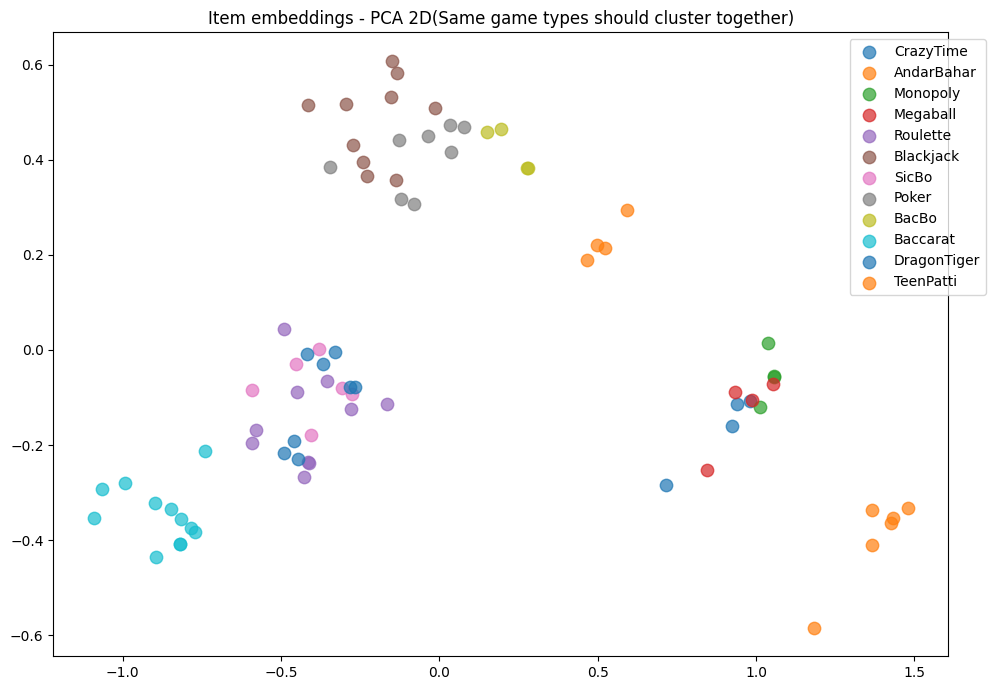

In [39]:
#Embedding space visualizations--> UMAP/PCA ka sabse explainable plot for item features
from sklearn.decomposition import PCA 

#item embeddings visualize karo
_, item_emb = model.get_item_representations(features = item_features_matrix)

pca = PCA(n_components = 2)
item_2d = pca.fit_transform(item_emb)

item_plot_df = pd.DataFrame({
    'x': item_2d[:, 0],
    'y': item_2d[:, 1],
    'gameType': [games_df[games_df['gameId'] == idx_to_game[i]].iloc[0]['gameType']
                 for i in range(len(item_id_map))]
})

plt.figure(figsize = (10, 7))
for gtype in item_plot_df['gameType'].unique():
    subset = item_plot_df[item_plot_df['gameType'] == gtype]
    plt.scatter(subset['x'], subset['y'], alpha = 0.7, s = 80, label = gtype)

plt.title("Item embeddings - PCA 2D(Same game types should cluster together)")
plt.legend(bbox_to_anchor = (1.05, 1))
plt.tight_layout()
plt.show()



This basically forms a cluster between different types of games

Similar games are grouped together

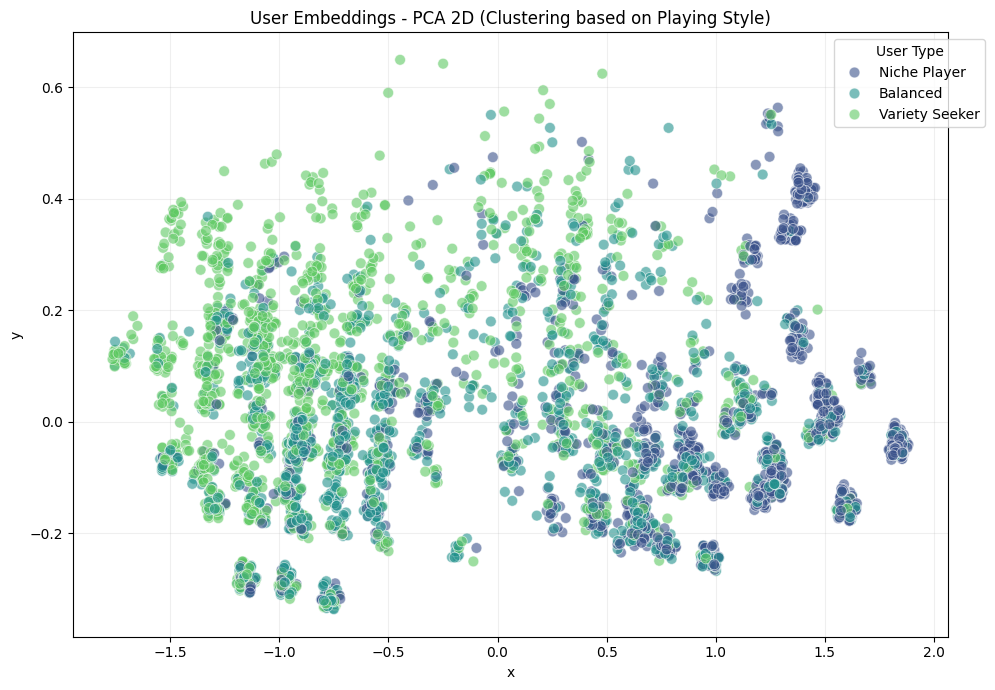

In [40]:
# 1. User representations nikaalo
_, user_emb = model.get_user_representations(features=user_features_matrix)

# 2. PCA se 2D mein convert karo
pca_u = PCA(n_components=2)
user_2d = pca_u.fit_transform(user_emb)

# 3. Visualization ke liye categorization (e.g., High vs Low Diversity users)
# Hum users ko unki 'diversity_ratio' ke basis par color karenge
user_plot_df = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'diversity': ufe['diversity_ratio'].values
})

# Diversity ko categories mein baant dete hain color karne ke liye
user_plot_df['Segment'] = pd.qcut(user_plot_df['diversity'], 3, labels=['Niche Player', 'Balanced', 'Variety Seeker'])

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=user_plot_df, x='x', y='y', 
    hue='Segment', palette='viridis', alpha=0.6, s=60
)

plt.title("User Embeddings - PCA 2D (Clustering based on Playing Style)")
plt.legend(title='User Type', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [42]:
#Final touch

# Select a random user from those who have test interactions
random_user = np.random.choice(users_with_test)

# 2. Get recommendations (Fix: user_id ko array banana padta hai matching item_ids length)
# Hum user_id ko n_items baar repeat karenge taaki dono arrays ki length same ho jaye
user_ids_array = np.repeat(random_user, n_items)
item_ids_array = np.arange(n_items)

scores = model.predict(
    user_ids=user_ids_array, 
    item_ids=item_ids_array, 
    user_features=user_features_matrix, 
    item_features=item_features_matrix
)

# 3. Top 5 items aur history nikaalo
top_items = np.argsort(-scores)[:5]
known_positives = train_interactions.tocsr()[random_user].indices

# 4. Result Print Karo
print(f"--- Recommendations for User ID: {idx_to_user[random_user]} ---")
print(f"User's History (Already Played): {[idx_to_game[i] for i in known_positives[:3]]}")
print("-" * 45)
print(f"{'Rank':<5} | {'Game Name':<20} | {'Model Score':<10}")
print("-" * 45)
for i, item_idx in enumerate(top_items):
    game_name = idx_to_game[item_idx]
    print(f"{i+1:<5} | {game_name:<20} | {scores[item_idx]:.4f}")

--- Recommendations for User ID: u_01956 ---
User's History (Already Played): ['1476017', '1476043']
---------------------------------------------
Rank  | Game Name            | Model Score
---------------------------------------------
1     | 1476005              | -3.8234
2     | 1476071              | -3.8262
3     | 1476002              | -3.8313
4     | 1476004              | -3.8463
5     | 1476003              | -3.8672


---
## CELL 8 — Auto Interpretation (Business + Modeling Takeaways)
> Converts ablation and correlation outputs into plain-English insights, direct/inverse drivers, and next actions.

In [98]:
# Auto-interpretation of feature impact outputs
# Expects `ablation_df` (from CELL 3C) and `corr_mat` (from CELL 6).

if 'ablation_df' not in globals() or 'corr_mat' not in globals():
    print('Please run CELL 3C and CELL 6 first so `ablation_df` and `corr_mat` are available.')
else:
    ab = ablation_df.copy()

    if 'delta_vs_full_p10' not in ab.columns:
        baseline_p10 = ab.loc[ab['variant'] == 'full', 'test_precision@10'].iloc[0] if (ab['variant'] == 'full').any() else ab['test_precision@10'].max()
        ab['delta_vs_full_p10'] = ab['test_precision@10'] - baseline_p10

    ab_sorted = ab.sort_values('delta_vs_full_p10')
    hurtful = ab_sorted[ab_sorted['delta_vs_full_p10'] > 0.0].copy()
    helpful = ab_sorted[ab_sorted['delta_vs_full_p10'] < 0.0].copy()

    print('================ INTERPRETATION SUMMARY ================')
    print('\nA) Feature-group impact from ablation')

    if len(helpful) > 0:
        print('  Most useful groups (dropping them hurts P@10):')
        for _, r in helpful.head(3).iterrows():
            print(f"   - {r['variant']}: ΔP@10 = {r['delta_vs_full_p10']:.4f}")
    else:
        print('  No group showed clear positive contribution under current setup.')

    if len(hurtful) > 0:
        print('  Potentially noisy groups (dropping them improves P@10):')
        for _, r in hurtful.sort_values('delta_vs_full_p10', ascending=False).head(3).iterrows():
            print(f"   - {r['variant']}: ΔP@10 = +{r['delta_vs_full_p10']:.4f}")
    else:
        print('  No group looked harmful (good sign).')

    best = ab.sort_values('test_precision@10', ascending=False).iloc[0]
    print(f"\n  Best variant by P@10: {best['variant']} (P@10={best['test_precision@10']:.4f}, AUC={best['test_auc']:.4f})")

    print('\nB) Directional association with model score (Spearman)')
    score_col = 'pred_score'
    if score_col not in corr_mat.columns:
        print('  `pred_score` not found in correlation matrix. Re-run CELL 6.')
    else:
        s = corr_mat[score_col].drop(score_col, errors='ignore').dropna().sort_values(ascending=False)

        top_pos = s.head(5)
        top_neg = s.tail(5)

        print('  Top direct (+) associations:')
        for feat, val in top_pos.items():
            print(f'   - {feat}: {val:.3f}')

        print('  Top inverse (-) associations:')
        for feat, val in top_neg.items():
            print(f'   - {feat}: {val:.3f}')

    print('\nC) Recommended next steps')
    print('  1. Keep groups with clearly negative ΔP@10 when dropped (they are helping).')
    print('  2. Prune or regularize groups that improve P@10 when dropped (possible noise).')
    print('  3. Validate feature stability with multiple random seeds.')
    print('  4. Use temporal split when real production data is available.')
    print('  5. Track segment metrics (new users, high-rollers, dormant), not just global metrics.')

    print('\nNote: Correlation indicates direction/association, not causality.')

================ INTERPRETATION SUMMARY ================

A) Feature-group impact from ablation
  Most useful groups (dropping them hurts P@10):
   - drop_user_context: ΔP@10 = -0.0155
   - drop_item_metadata: ΔP@10 = -0.0084
  Potentially noisy groups (dropping them improves P@10):
   - drop_item_popularity: ΔP@10 = +0.0016
   - drop_user_behavior: ΔP@10 = +0.0011

  Best variant by P@10: drop_item_popularity (P@10=0.0590, AUC=0.7900)

B) Directional association with model score (Spearman)
  Top direct (+) associations:
   - diversity_ratio: 0.574
   - unique_players: 0.426
   - popularity_score: 0.231
   - total_plays: 0.231
   - last_played_days_ago: 0.182
  Top inverse (-) associations:
   - avg_session_min: -0.471
   - avg_session_duration: -0.551
   - sessions_last_7d: -0.572
   - sessions_last_30d: -0.663
   - total_sessions: -0.696

C) Recommended next steps
  1. Keep groups with clearly negative ΔP@10 when dropped (they are helping).
  2. Prune or regularize groups that improv

Actionable Next Steps for Dev/Prod

1. Keep groups with clearly negative ΔP@10 when dropped (they are helping).
2. Prune or regularize groups that show positive ΔP@10 when dropped (possible noise).
3. Validate stability with 3 random seeds before finalizing feature set.
4. Switch to temporal split for production-like offline evaluation.
5. Track segment metrics (new users, high-rollers, dormant) not only global P@10/AUC.

*Note: Correlation indicates direction/association, not causality.*